In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy
import seaborn
import matplotlib
import requests
import codecs
import re
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

with open("file.csv", 'w', encoding='utf-8') as file:
    file.write(requests.get(
        "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-11-03/ikea.csv").text)
df = pd.read_csv("file.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3694 entries, 0 to 3693
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         3694 non-null   int64  
 1   item_id            3694 non-null   int64  
 2   name               3694 non-null   object 
 3   category           3694 non-null   object 
 4   price              3694 non-null   float64
 5   old_price          3694 non-null   object 
 6   sellable_online    3694 non-null   bool   
 7   link               3694 non-null   object 
 8   other_colors       3694 non-null   object 
 9   short_description  3694 non-null   object 
 10  designer           3694 non-null   object 
 11  depth              2231 non-null   float64
 12  height             2706 non-null   float64
 13  width              3105 non-null   float64
dtypes: bool(1), float64(4), int64(2), object(7)
memory usage: 378.9+ KB


In [4]:
df.describe()

Unnamed: 0       item_id        price        depth       height  \
count  3694.000000  3.694000e+03  3694.000000  2231.000000  2706.000000   
mean   1846.500000  4.863240e+07  1078.208419    54.379202   101.679970   
std    1066.510275  2.888709e+07  1374.652494    29.958351    61.097585   
min       0.000000  5.848700e+04     3.000000     1.000000     1.000000   
25%     923.250000  2.039057e+07   180.900000    38.000000    67.000000   
50%    1846.500000  4.928808e+07   544.700000    47.000000    83.000000   
75%    2769.750000  7.040357e+07  1429.500000    60.000000   124.000000   
max    3693.000000  9.993262e+07  9585.000000   257.000000   700.000000   

             width  
count  3105.000000  
mean    104.470853  
std      71.133771  
min       1.000000  
25%      60.000000  
50%      80.000000  
75%     140.000000  
max     420.000000

У базі даних представлено перелік продажів. Всього 3694 позиції. Є номер товару та назви. Кожен товар має свою категорію. Є такі ознаки товару як продаж online та наявність іншого кольору. Є ціна і стара ціна. Дані за цими ознаками є у всіх позиціях. Для аналізу old_price необхідно перевести у float (представлена у форматі object), а дані sellable_online у int. Інформація про розміри представлена не в повному обсязі. Отримуємо статистичні дані для уявлення про числові дані.

In [30]:
list_item_id = numpy.unique(df['item_id'])  
print(list_item_id.__len__(),'кількість унікальних id') 
list_name = numpy.unique(df['name'])  
print(list_name.__len__(),'кількість унікальних name')
list_category = numpy.unique(df['category'])  
print(list_category.__len__(),'кількість унікальних category')
list_designer = numpy.unique(df['designer'])
print(list_designer.__len__(),'кількість унікальних')

count_category = df.groupby('category').count()
count_category.iloc[:,[0]]

2962 кількість унікальних id
607 кількість унікальних name
17 кількість унікальних category
381 кількість унікальних


Unnamed: 0
category            
1                 47
2                208
3                548
4                292
5                 26
6                481
7                125
8                124
9                 97
10               216
11                13
12                23
13               428
14               190
15               612
16                28
17               236

Судячи з кількості id і name, аналізувати ціни за цими даними не можна.
Є 17 категорій – можна використовувати для аналізу та прогнозу цін.
Найбільше продажів було товарів категорій Bookcases & shelving units
Chairs ,Sofas & armchairs ,Tables & desks

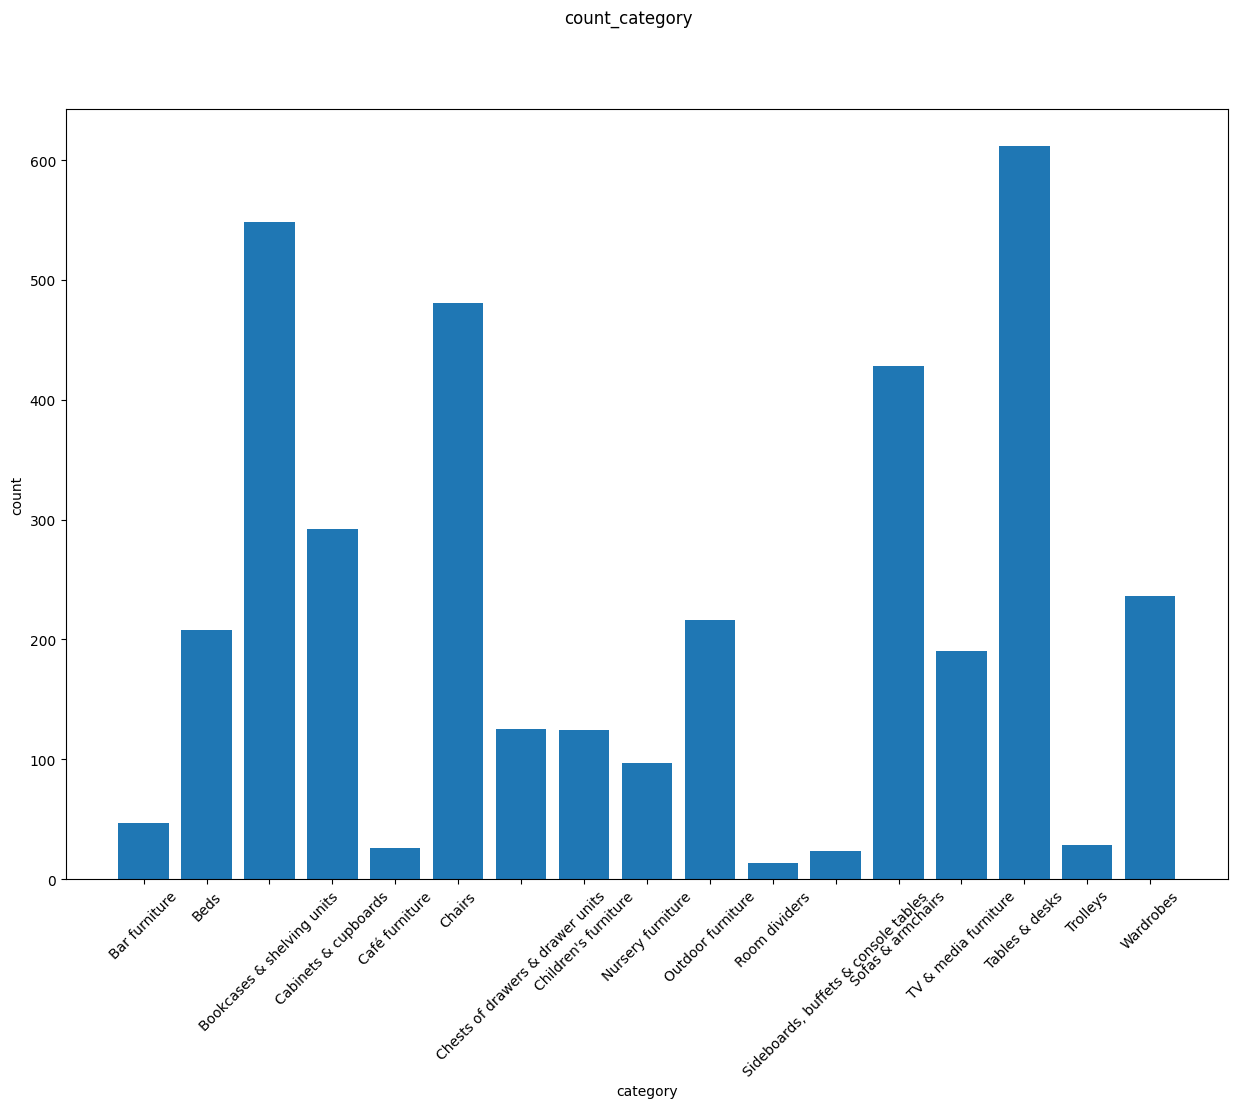

In [6]:
count_list = count_category.iloc[:, 0].tolist()
categories = count_category.index.tolist()
fig, ax = plt.subplots(figsize=(15, 10))
ax.bar(categories, count_list)
ax.set_xticks(range(len(list_category)))
ax.set_xticklabels(categories, rotation=45)
plt.xlabel('category')
plt.ylabel('count')
plt.suptitle('count_category')
plt.show()

Кількість дизайнерів 381. Найменування необхідно уніфікувати.
Для зручності створюємо новий стовпець 'new_designer', в якому прибираємо
зайві дані. Вважаємо, що якщо імені дизайнера немає, а внесено
опис товару - вважаємо такий товар серійним

In [31]:
list_designer = numpy.unique(df['designer'])
df['new_designer'] = df['designer'].copy()
for x in range(df['new_designer'].__len__()):
    designer_split = df.loc[x, 'new_designer'].split('/')
    filtered_data = list(filter(lambda x: "ikea" not in x.lower(), designer_split))
    if len(filtered_data) >= 1:
        df.loc[x, 'new_designer'] = filtered_data[0]

mask = (df['new_designer'].str.len() > 50)
df.loc[mask, 'new_designer'] = 'IKEA'

for x in range(df['new_designer'].__len__() - 1):
    if df.loc[x, 'new_designer'] == '304.510.67':
        df.loc[x, ['new_designer']] = 'IKEA'
    elif df.loc[x, 'new_designer'] == '704.510.65':
        df.loc[x, ['new_designer']] = 'IKEA'
    elif df.loc[x, 'new_designer'] == 'IKEA of Sweden':
        df.loc[x, ['new_designer']] = 'IKEA'

list_new_designer = numpy.unique(df['new_designer'])
print(list_new_designer.__len__(),'кількість дизайнерів')

84 кількість дизайнерів


У зв'язку з тим, що кількість унікальних товарів досить велика,
аналізувати продажі за конкретними товарами недоцільно.
Можна зробити аналіз з обсягів продажів за ціновими сегментами. Як видно
  з графіка нижче - вищий рівень продажів посідає дешевший товар.

[ 265.  995. 2095. ...  924. 2745. 1231.]


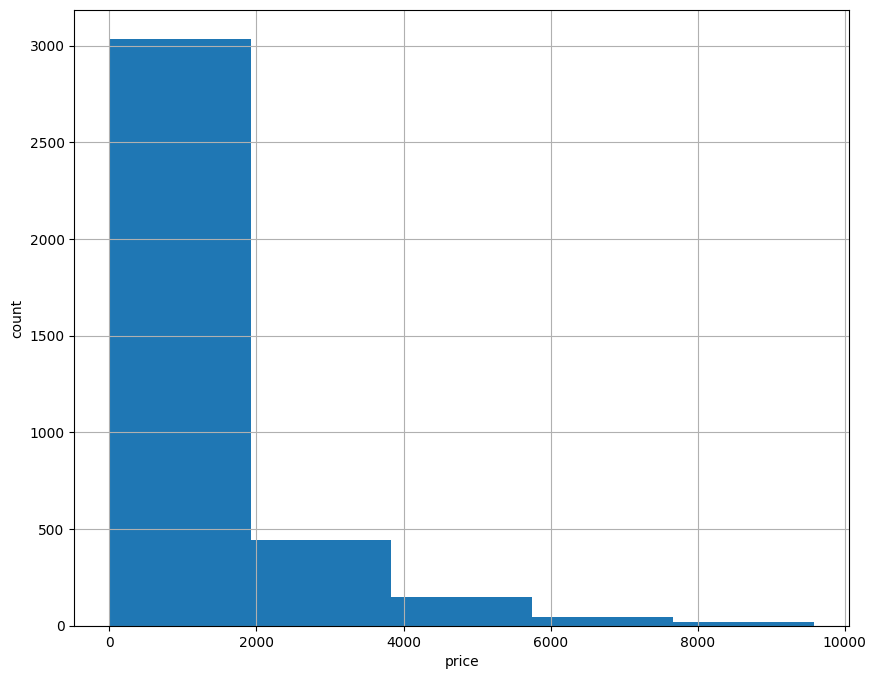

In [9]:
list_price = numpy.array(df['price'].tolist())
print(list_price)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()
ax.hist(list_price, 5)
ax.grid()
plt.xlabel('price')
plt.ylabel('count')
plt.show()

Нульова гіпотеза – обсяг продажу товарів не залежить від можливості вибрати товар з іншим кольором

[1512, 2182]
Продаж товарів з наявністю іншого кольору складає 59.07% процентів


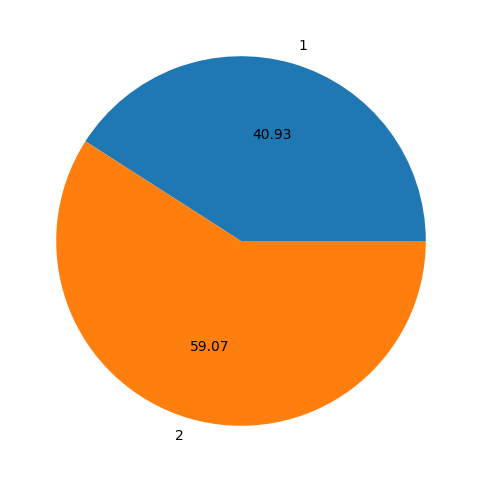

In [32]:

list_other_colors = numpy.unique(df['other_colors'])
count_other_colors = df.groupby('other_colors').count()
list_count_other_colors = count_other_colors.iloc[:, 0].tolist()
print(list_count_other_colors)
print('Продаж товарів з наявністю іншого кольору складає {:.2f}%'.format(
    (list_count_other_colors[1] / df['other_colors'].count()) * 100), 'процентів')
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(list_count_other_colors, labels=list_other_colors, autopct='%.2f')
plt.show()


Як бачимо згідно з графіком обсягу продажів від наявності іншого кольору практично не залежать.

Альтернативна гіпотиза: продаж товарів залежать від можливості продажу online

Продаж товарів online складає 99.24% процентів


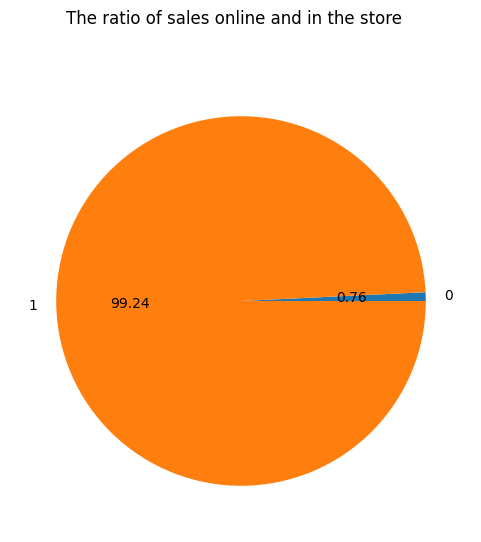

In [33]:

list_sellable_online = numpy.unique(df['sellable_online'])
count_sellable_online = df.groupby('sellable_online').count()
list_count_sellable_online = count_sellable_online.iloc[:, 0].tolist()

print('Продаж товарів online складає {:.2f}%'.format(
    (list_count_sellable_online[1] / df['sellable_online'].count()) * 100), 'процентів')

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(list_count_sellable_online, labels=list_sellable_online, autopct='%.2f')
plt.suptitle('The ratio of sales online and in the store')
plt.show()













Гіпотеза підтверджується. Більшість товарів продається online.










Нульова гіпотиза: обсяги продажів не залежать від того, що товар від відомого дизайнера або це серійний товар (IKEA)

           new_designer  count
0         A Fredriksson      8
1              A Huldén      1
2   Andreas Fredriksson     29
3        Anna Efverlund      4
4      Anna Palleschitz      2
..                  ...    ...
79     Tina Christensen     26
80            Tom Dixon     28
81       Tord Björklund     54
82         Virgil Abloh      7
83       Wiebke Braasch      2

[84 rows x 2 columns]


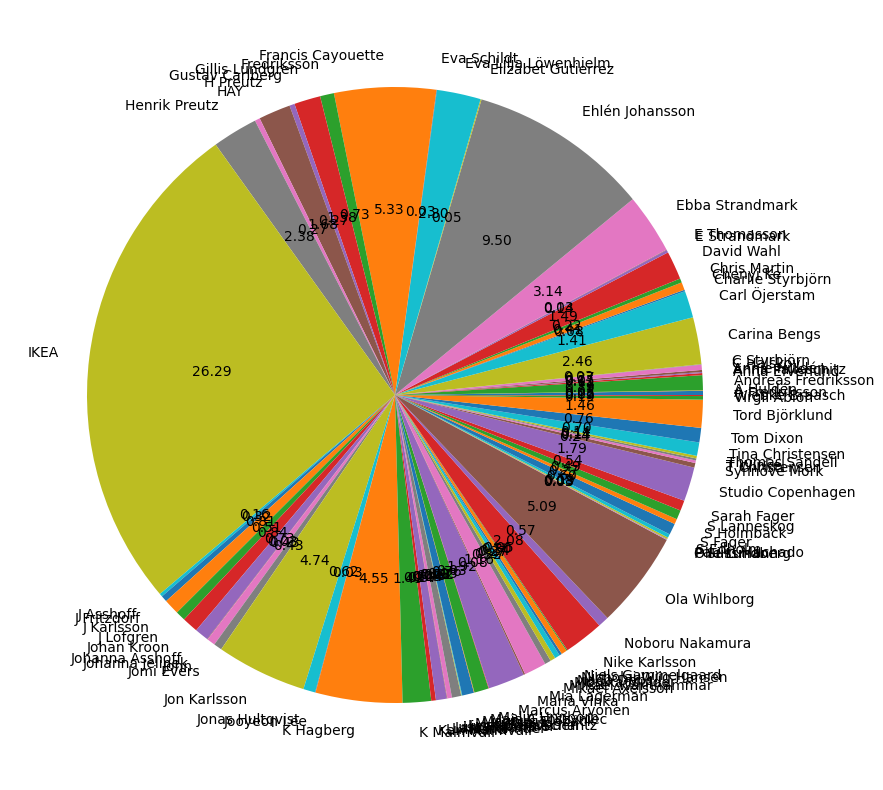

In [12]:
designer_count = {}
for x in list_new_designer:
    designer_count[x]=df.loc[df['new_designer'] == x].count()
    designer_count[x] = designer_count[x]['new_designer']


df_designer_count = pd.DataFrame(list(designer_count.items()), columns=['new_designer', 'count'])
print(df_designer_count)



x = numpy.array(df_designer_count.loc[:,'new_designer'])
y = numpy.array(df_designer_count.loc[:,'count'])
fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(y, labels=x, autopct='%.2f')
plt.show()



висновок: Продаж серійного товару складає 26.29% Решта товарів від різних дизайнерів

Гіпотеза: Виторг від продажу кожного дизайнера залежить від кількості проданого товару

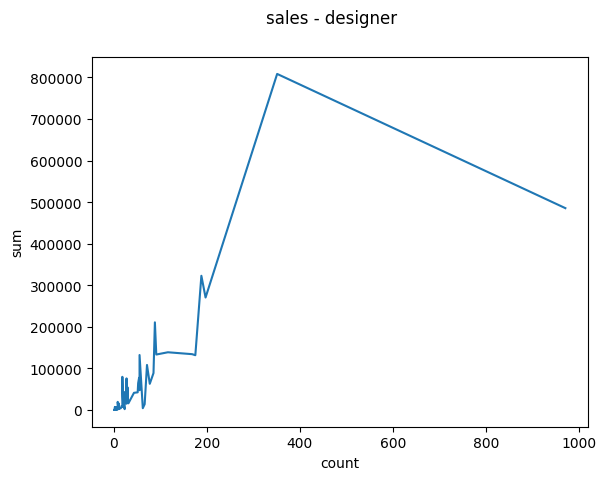

In [13]:
designer_sum = {}
designer_c = {}
for x in list_new_designer:
    designer_sum[x]=df.loc[df['new_designer'] == x]['price'].sum()

    designer_c[x]=df.loc[df['new_designer'] == x].count()
    designer_c[x] = designer_c[x]['new_designer']
df_designer_sum = pd.DataFrame(list(designer_sum.items()), columns=['designer', 'sum'])
df_designer_c = pd.DataFrame(list(designer_c.items()), columns=['designer', 'count'])

x = numpy.array(df_designer_c.loc[:,'count'])
y = numpy.array(df_designer_sum.loc[:,'sum'])

sort_indices = numpy.argsort(x)

x_sorted = x[sort_indices]
y_sorted = y[sort_indices]


plt.xlabel('count')
plt.ylabel('sum')
plt.suptitle('sales - designer')

plt.plot(x_sorted, y_sorted)
plt.show()

Висновок: сума від продажу товару за кожним дизайнером залежить від кількості товару. Але є винятки – у деяких дизайнерів ціна товару вища.





Гіпотиза: ціна товару не залежить від розміру товару
Для перевірки цієї гіпотизи видалили рядки в якому є заповнені осередки з розмірами і додали стовпець 'volume'(добуток 'depth','height','width' )

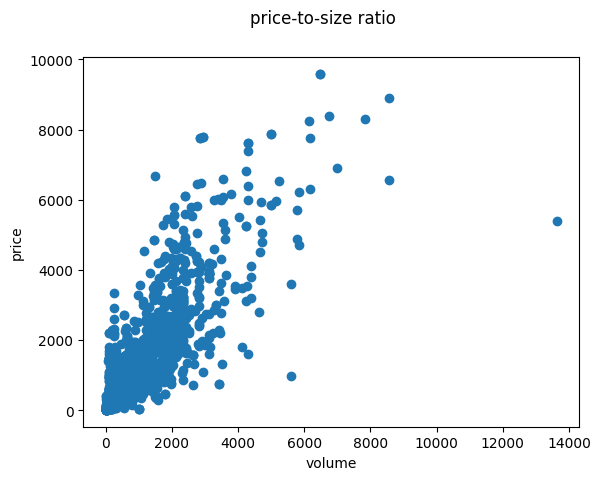

In [14]:
df_1 = df.copy()
df_1.dropna(subset=['depth','height','width'], inplace=True)# видалили строки без значень

df_1['volume'] = df_1.apply(lambda row: row['depth']/10 * row['height']/10 * row['width']/10, axis=1)

x_volume = list(df_1['volume'])
y_price = list(df_1['price'])

plt.scatter(x_volume,y_price)
plt.xlabel('volume')
plt.ylabel('price')
plt.suptitle('price-to-size ratio')

plt.show()

Гіпотеза не підтвердилася: у більшості випадків товар з більшими розмірами коштує дорожче

Для створення моделі передбачення ціни :
-стовбець 'old_price' наводимо до цифрової форми. Якщо значення відсутнє підставляємо до нього значення зі стовбця 'price';
- додамо стовбець discount -  процент знижки  .

In [15]:

result = []
for i in range(df['old_price'].__len__()):
    match = re.search(r'[\d.,]+', df.loc[i, 'old_price'])
    if match:
        res = match.group()  # забираємо значення, що збіглося
        number_str = res.replace(',', '')  # замінюємо кому на точку для правильного перетворення на число

        df.loc[i, 'old_price'] = number_str
    else:
        df.loc[i, 'old_price'] = df.loc[i, 'price']

df['old_price'] = df['old_price'].astype(float)

df['discount'] = (round((df['old_price'] - df['price'])/df['old_price']*100))


заміна порожніх значень на 0

In [16]:
df[['depth', 'height','width']] = df[['depth', 'height','width']].fillna(0)

переведення category в числові значення

In [17]:
list_category = {'Bar furniture':1, 'Beds':2, 'Bookcases & shelving units':3,
 'Cabinets & cupboards':4, 'Café furniture':5, 'Chairs':6,
 'Chests of drawers & drawer units':7, "Children's furniture":8,
 'Nursery furniture':9, 'Outdoor furniture':10, 'Room dividers':11,
 'Sideboards, buffets & console tables':12, 'Sofas & armchairs':13,
 'TV & media furniture':14, 'Tables & desks':15, 'Trolleys':16, 'Wardrobes':17}

df['category'] = df['category'].map(list_category)


переведення other_colors в числові значення

In [18]:
list_other_colors = {'Yes':1, 'No':2}
df['other_colors'] = df['other_colors'].map(list_other_colors)

переведення sellable_online c bool в int 

In [19]:
list_sellable_online = {True:1, False:0}


df['sellable_online'] = df['sellable_online'].astype(int)
df['sellable_online'] = df['sellable_online'].fillna(0).astype(int)
df['sellable_online'] = df['sellable_online'].replace([numpy.inf, -numpy.inf], numpy.nan).fillna(0).astype(int)


Створюємо графіки залежності дисконту від усіх інших показників

<Figure size 640x480 with 0 Axes>

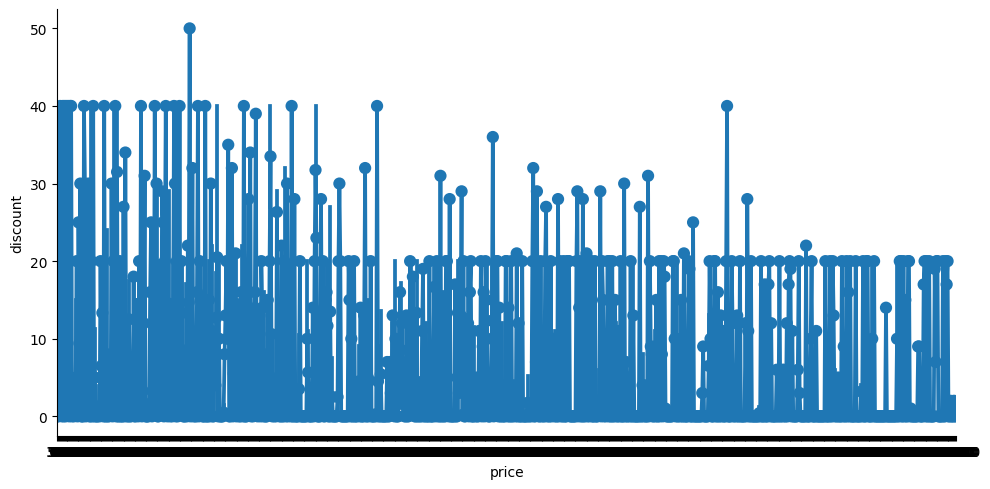

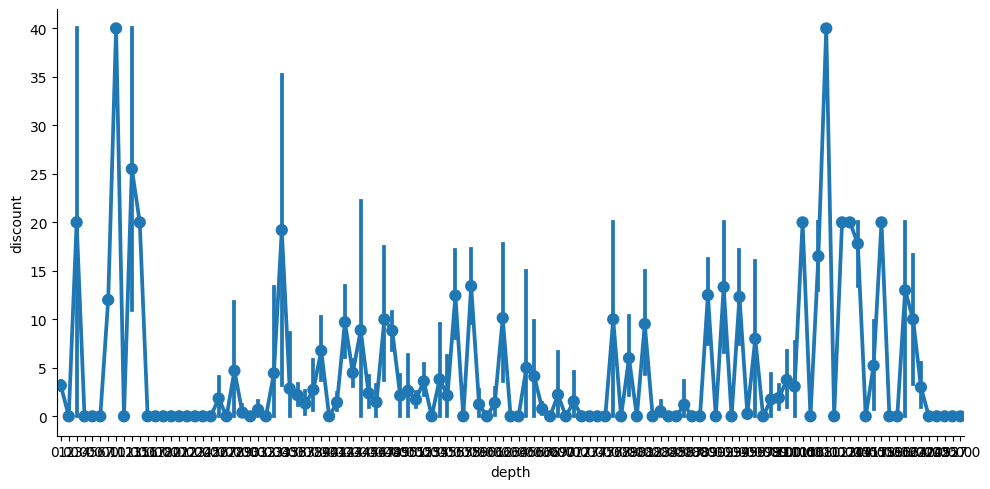

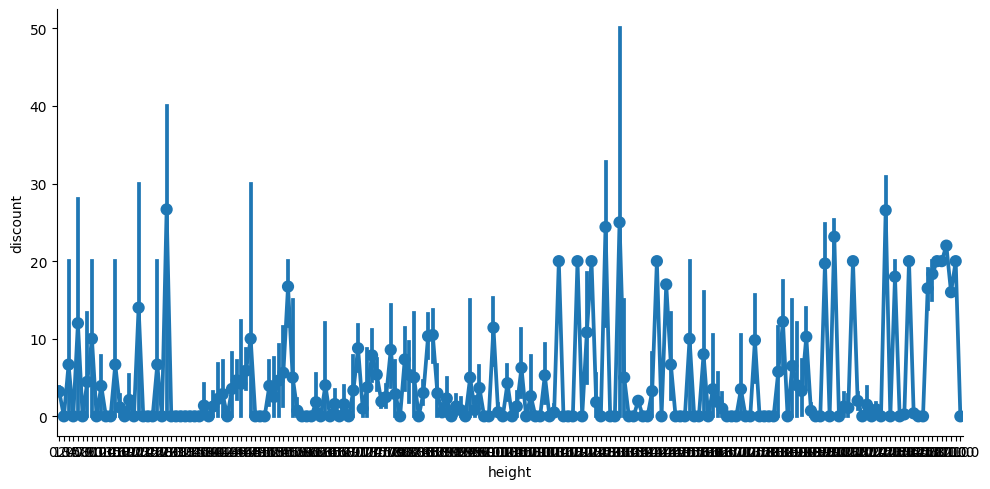

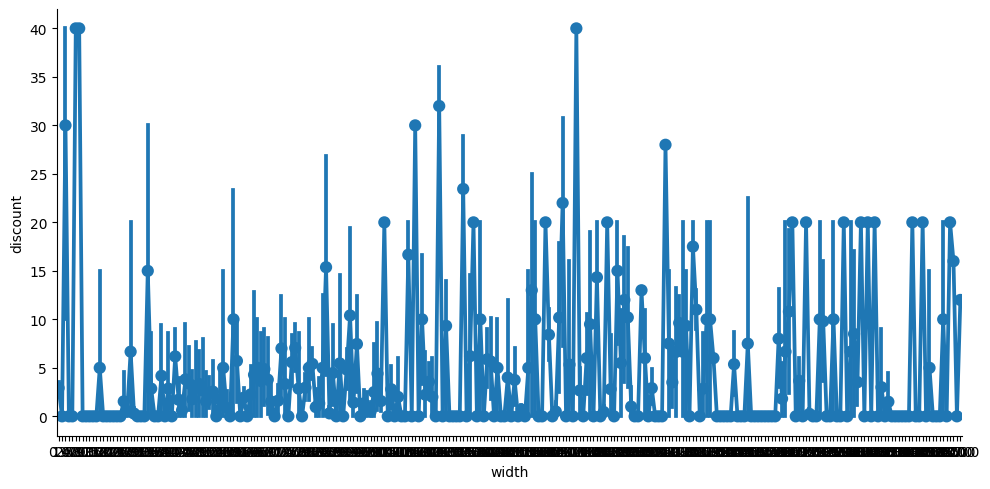

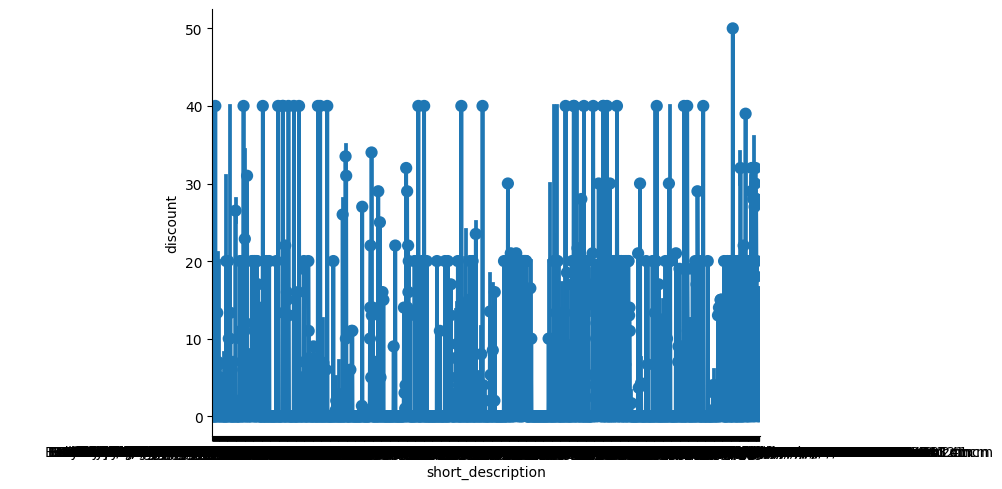

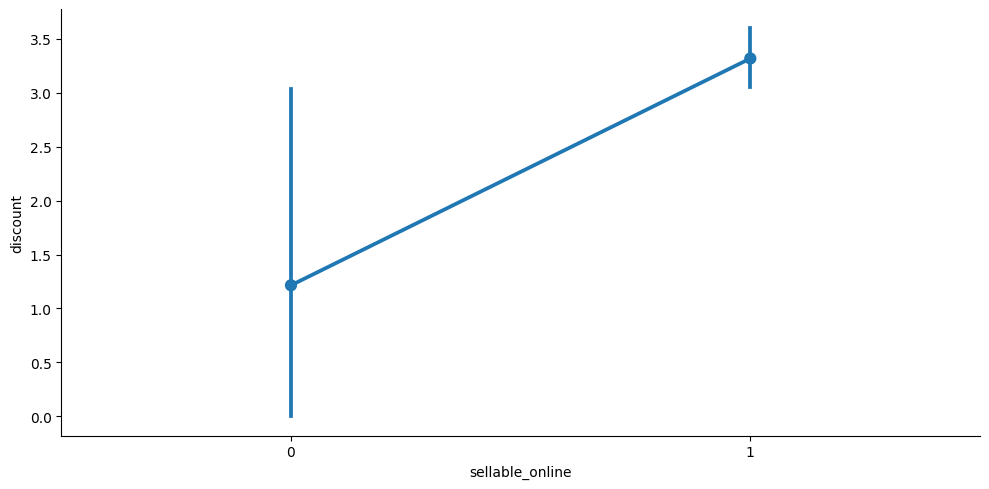

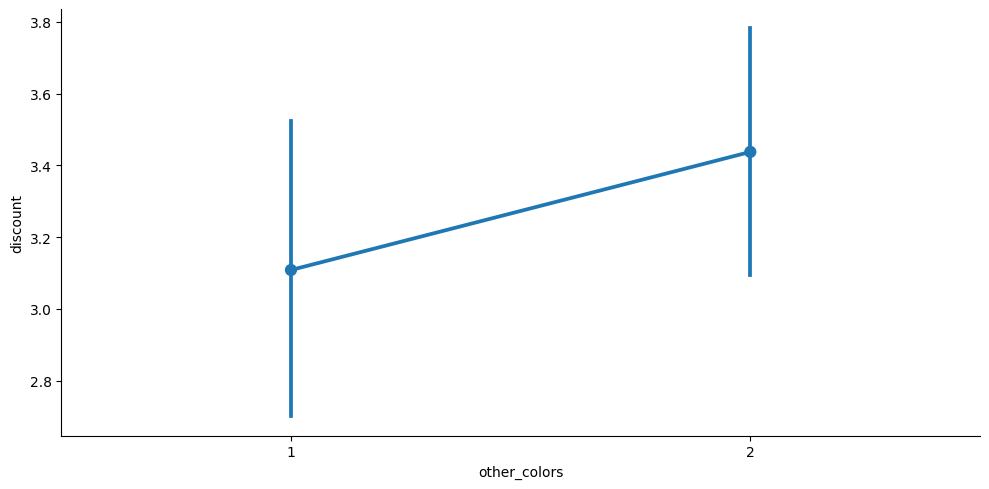

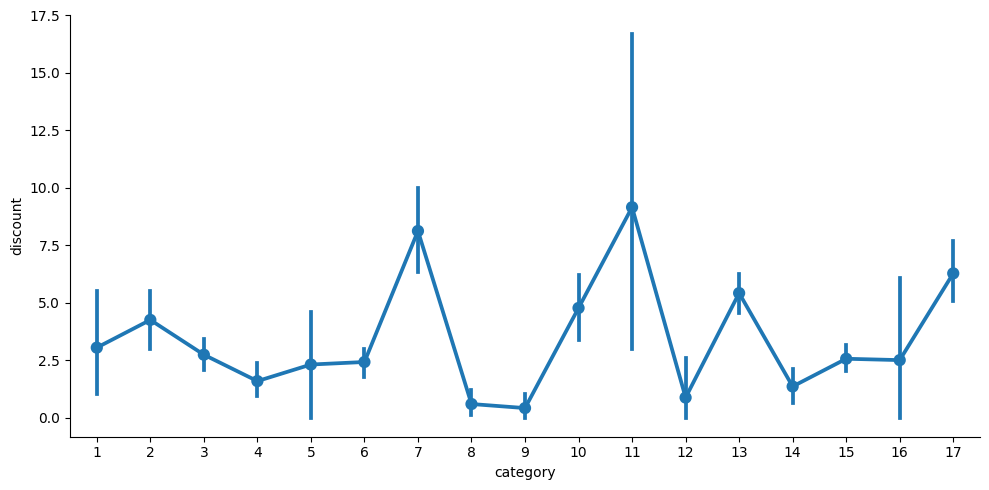

In [20]:

for i  , col in enumerate(['price','depth','height','width','short_description','sellable_online','other_colors','category']):
    plt.figure(i)
    seaborn.catplot(x=col,y='discount', data=df,kind='point',aspect=2,)


За графіками видно, що найбільша залежність простежується від продажу online, наявність іншого кольору. Кожен дизайнер має свій діапазон дисконту.
     Проведемо такий самий аналіз за категоріями
    



c:\Users\irina\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


<Figure size 640x480 with 0 Axes>

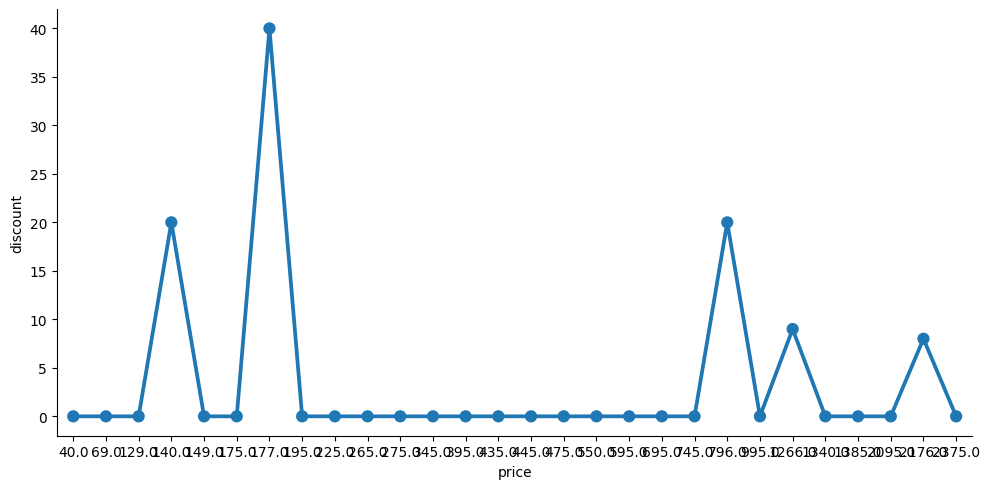

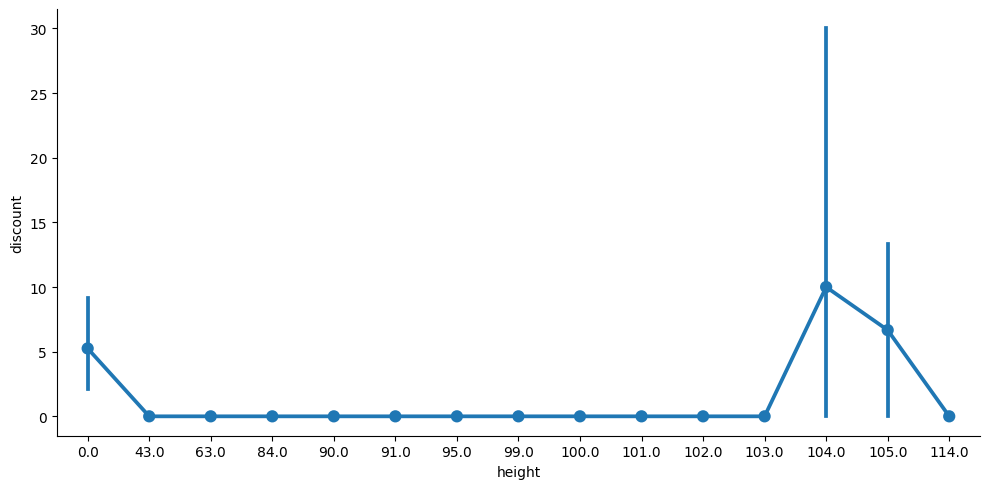

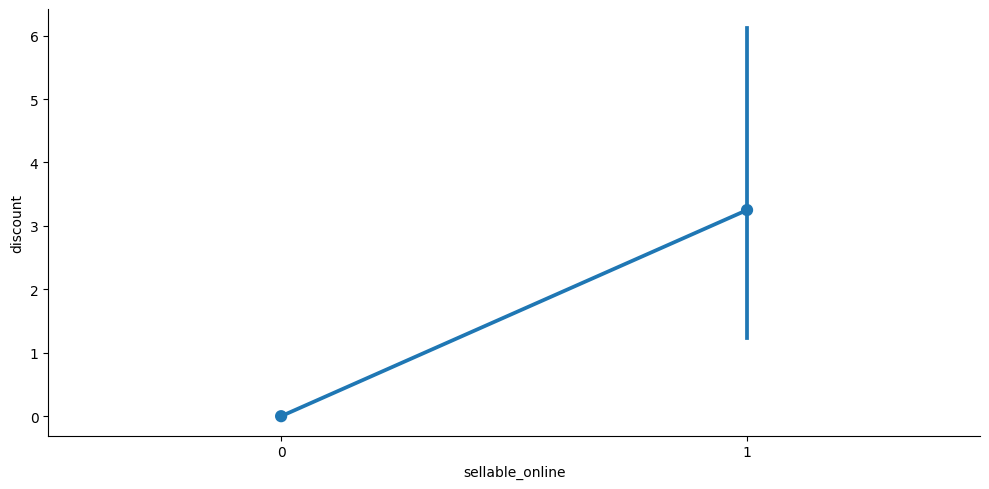

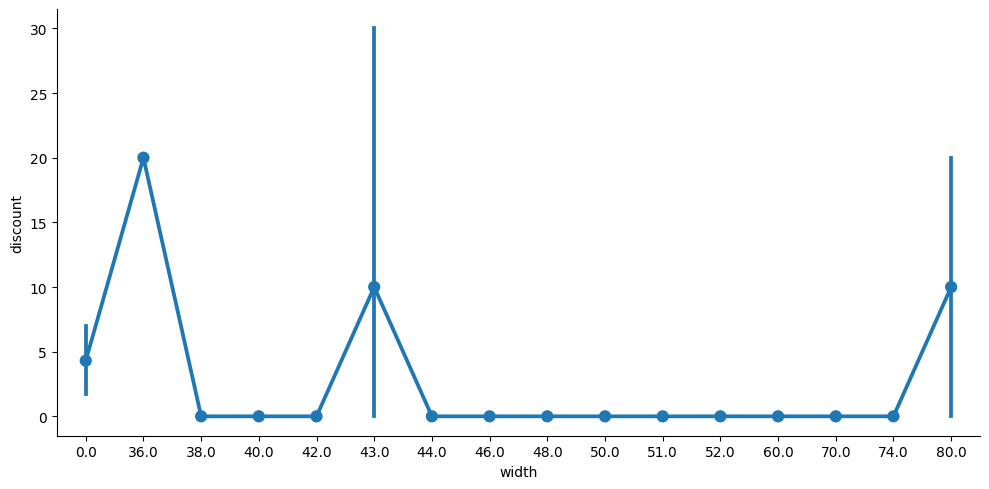

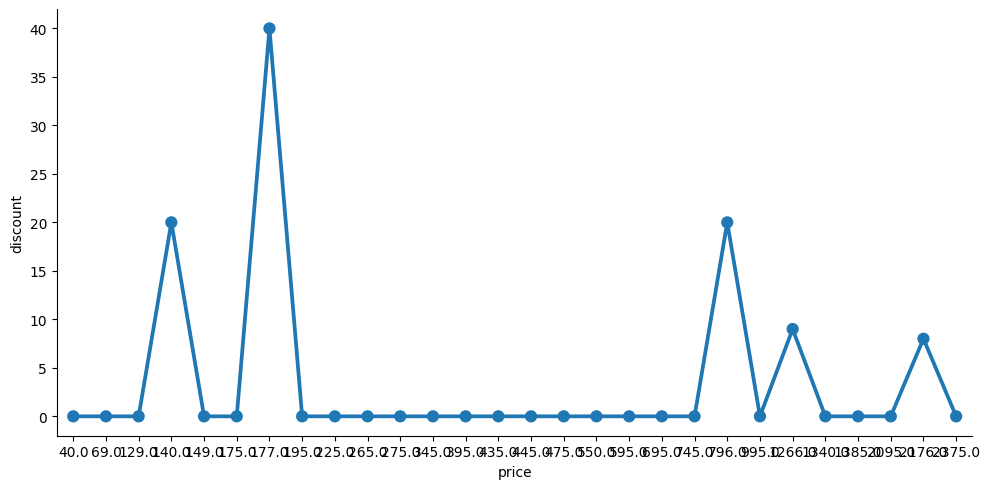

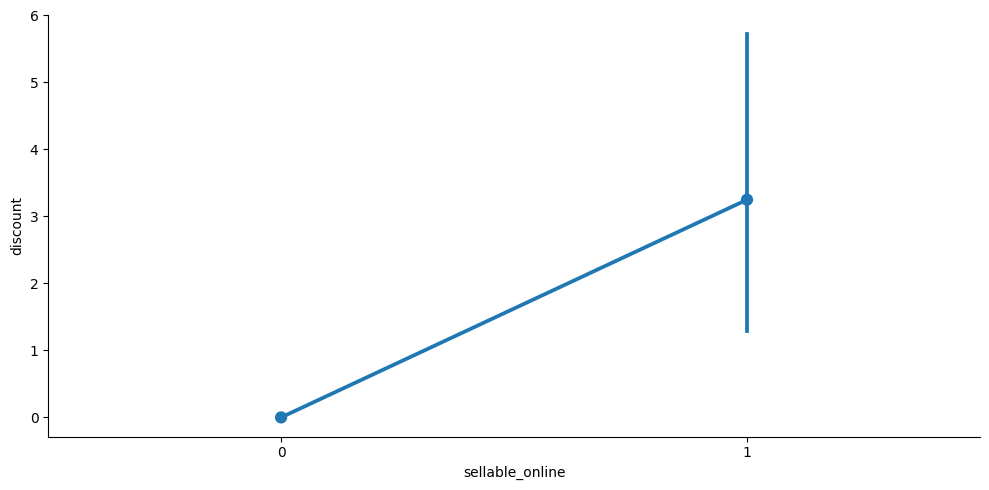

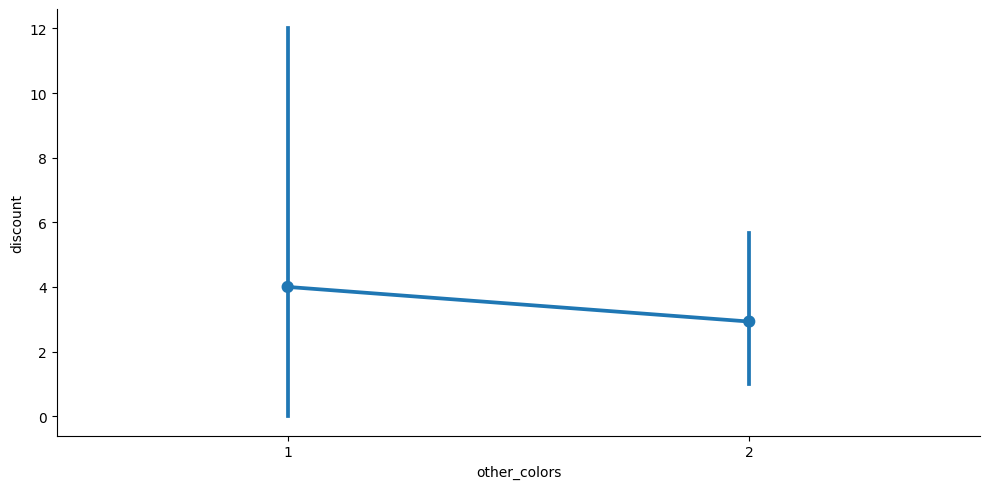

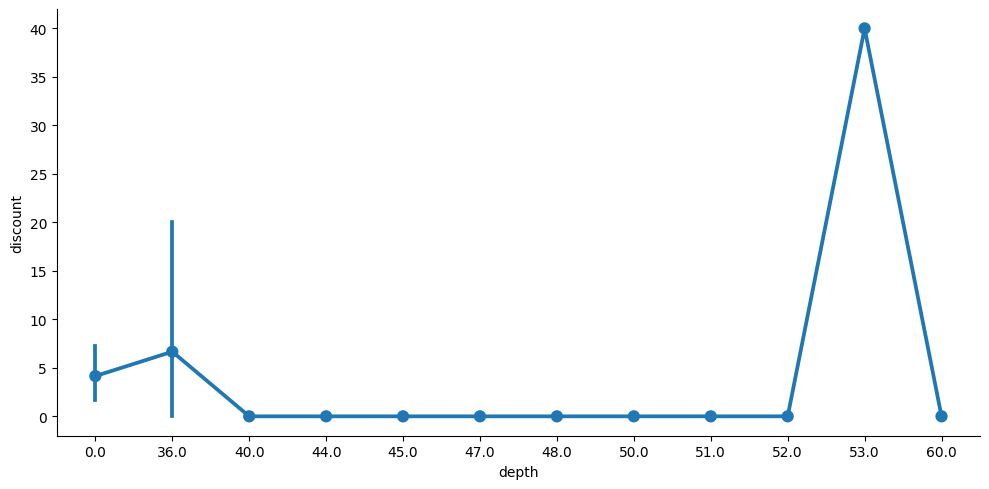

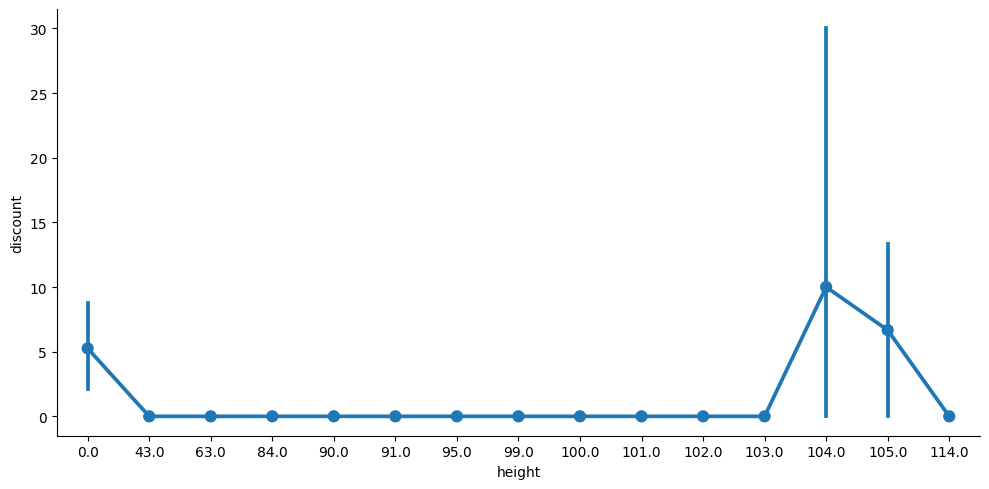

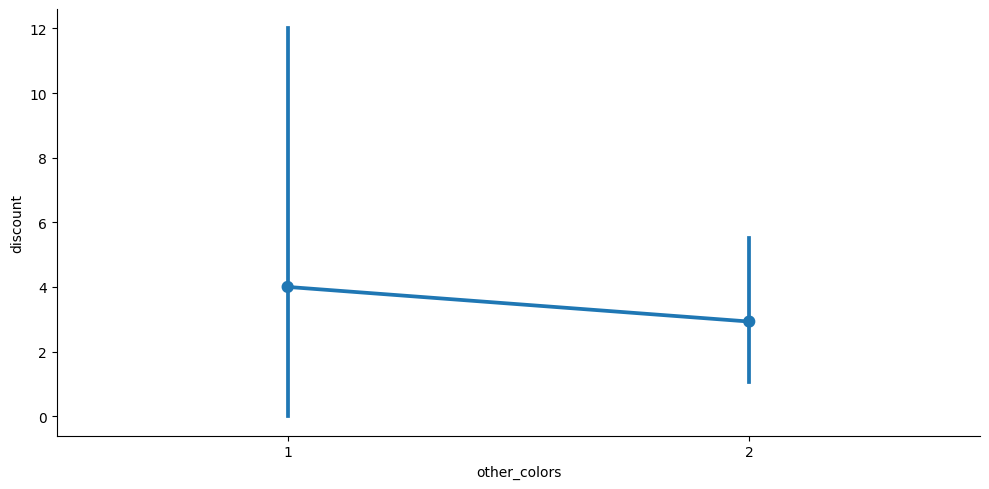

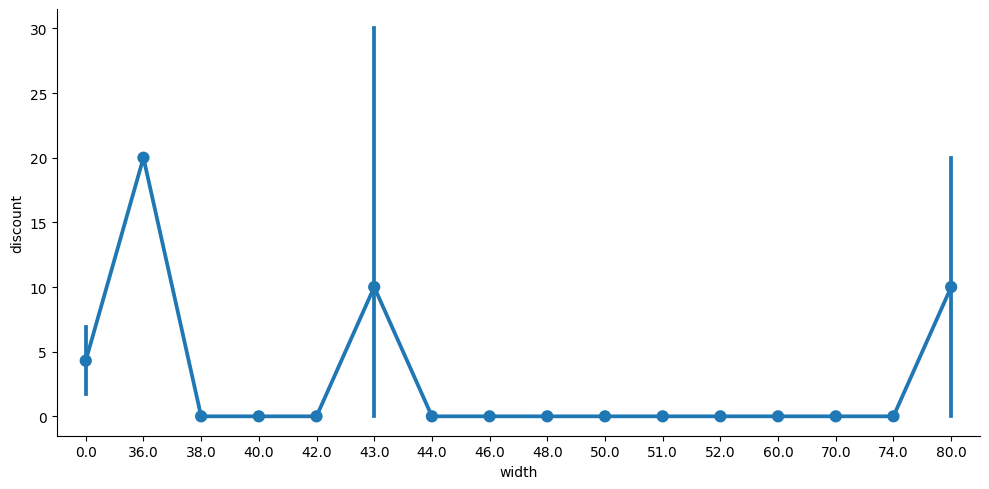

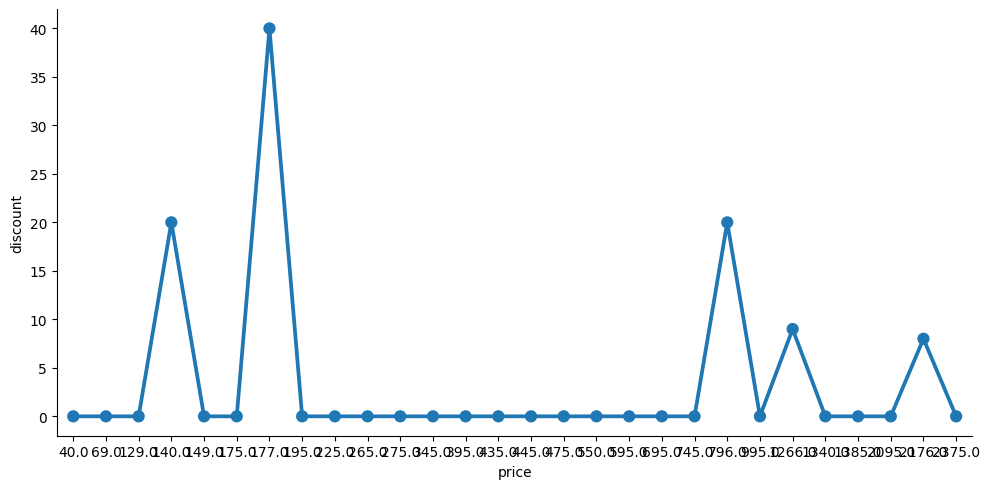

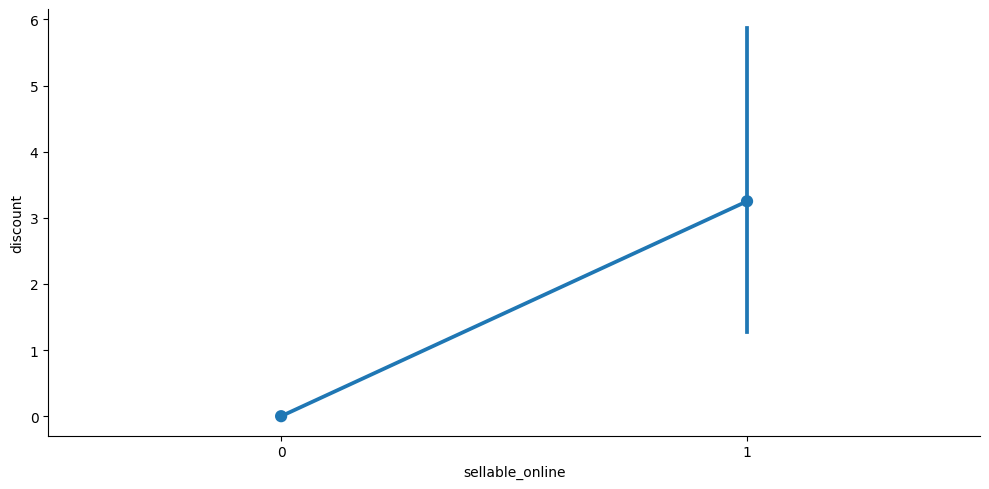

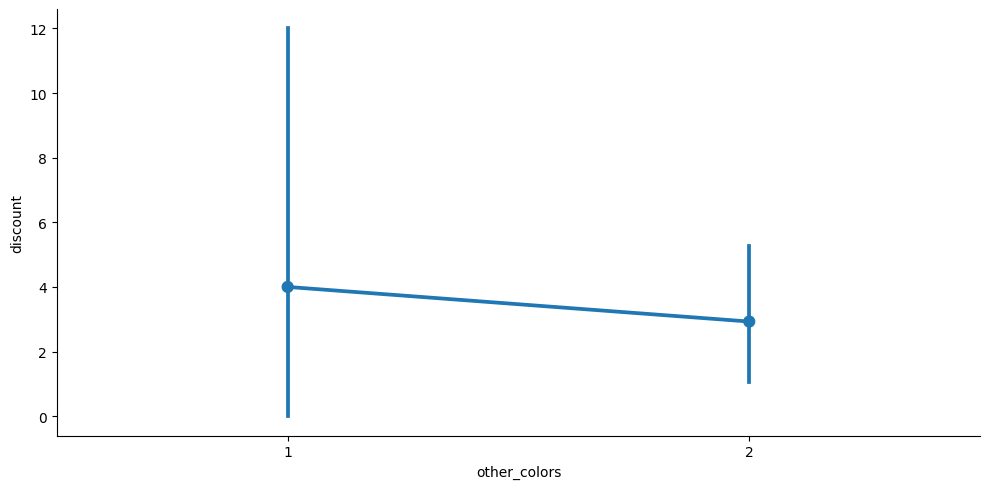

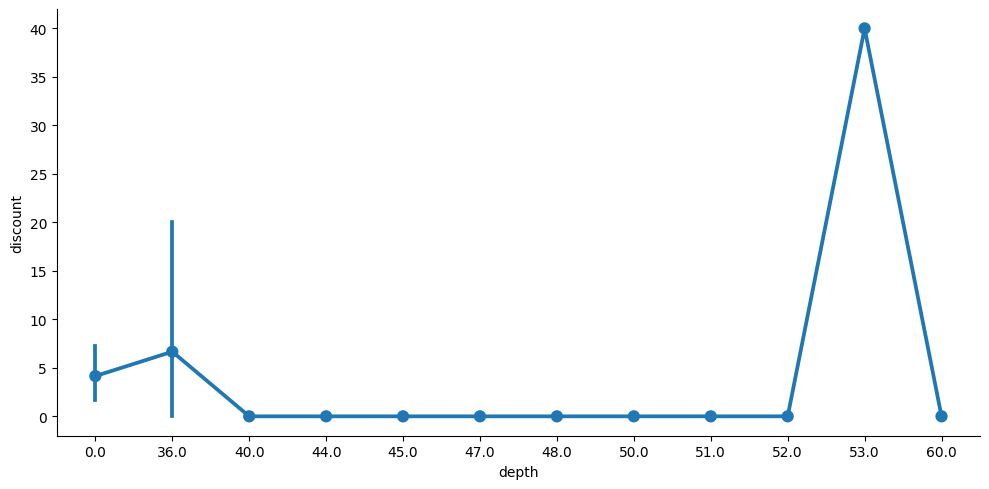

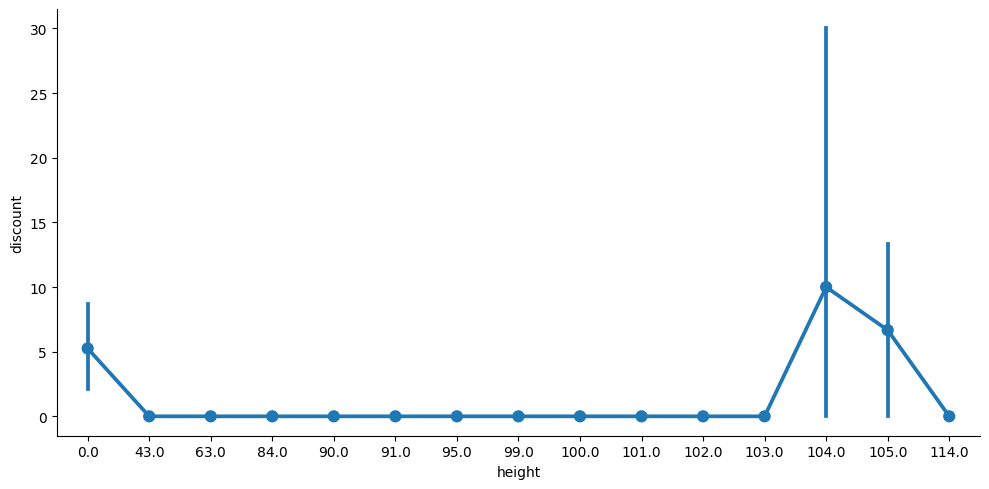

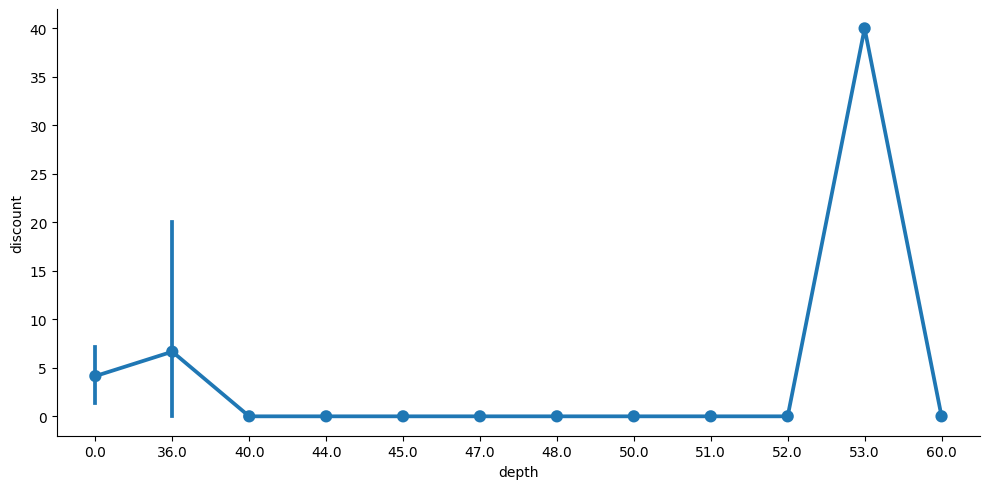

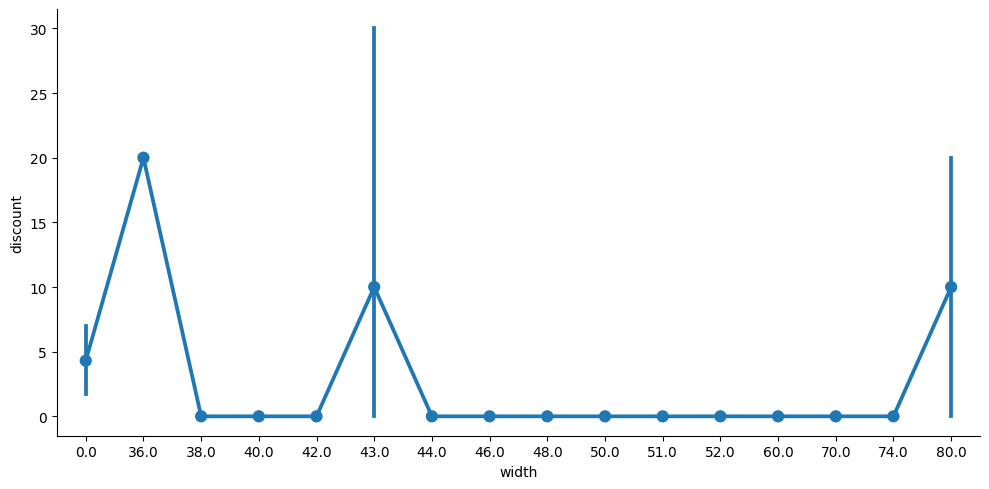

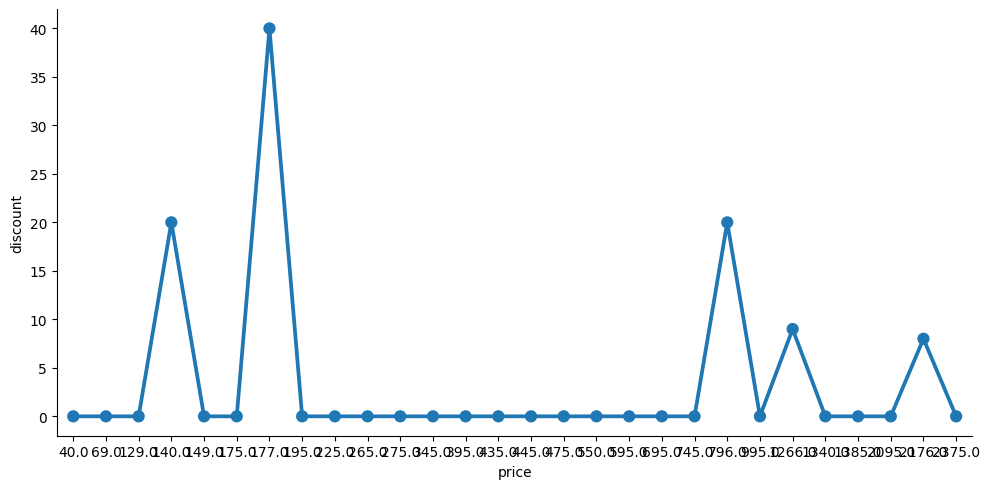

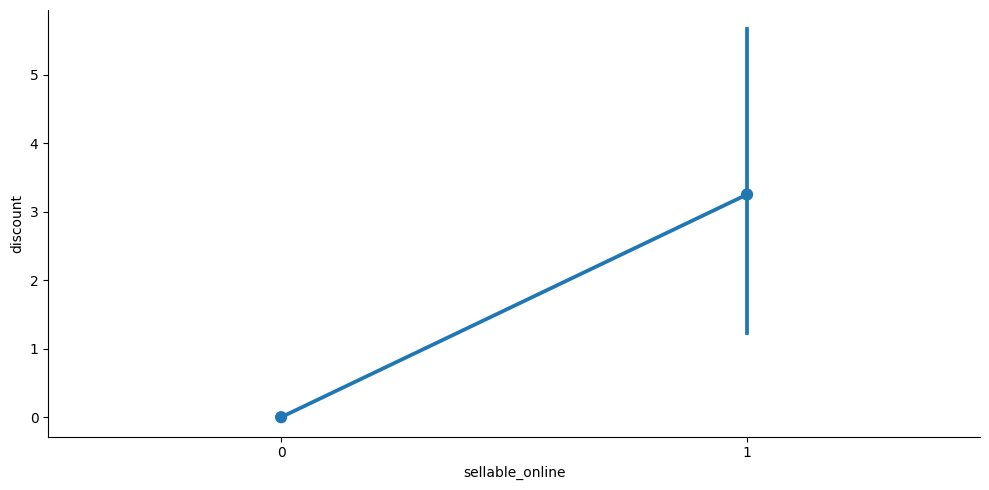

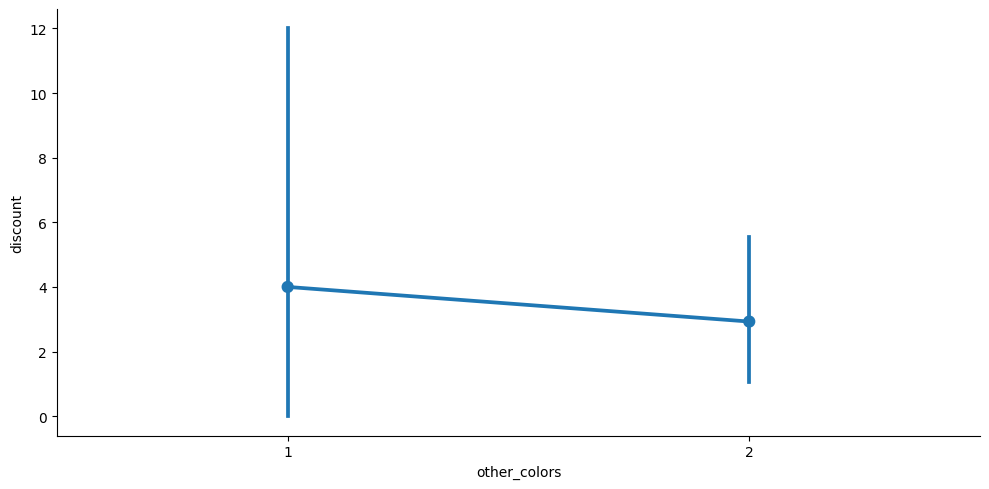

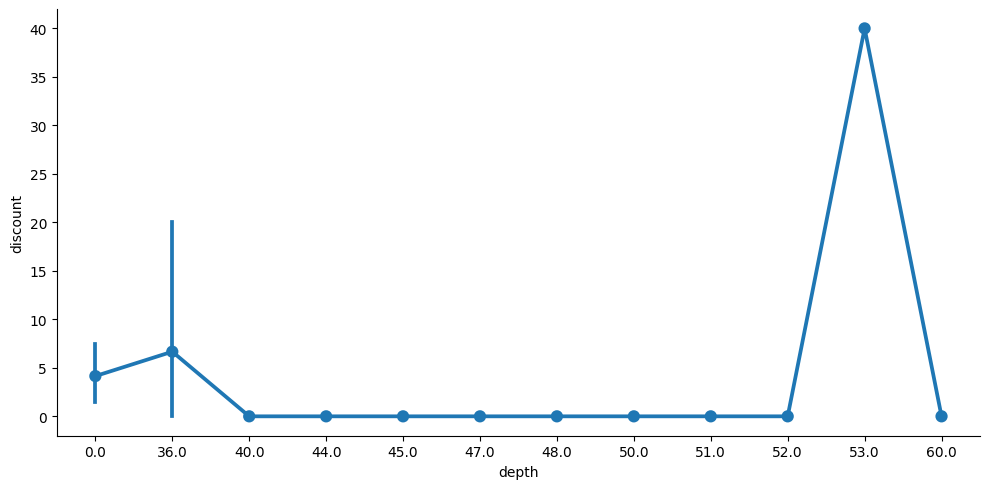

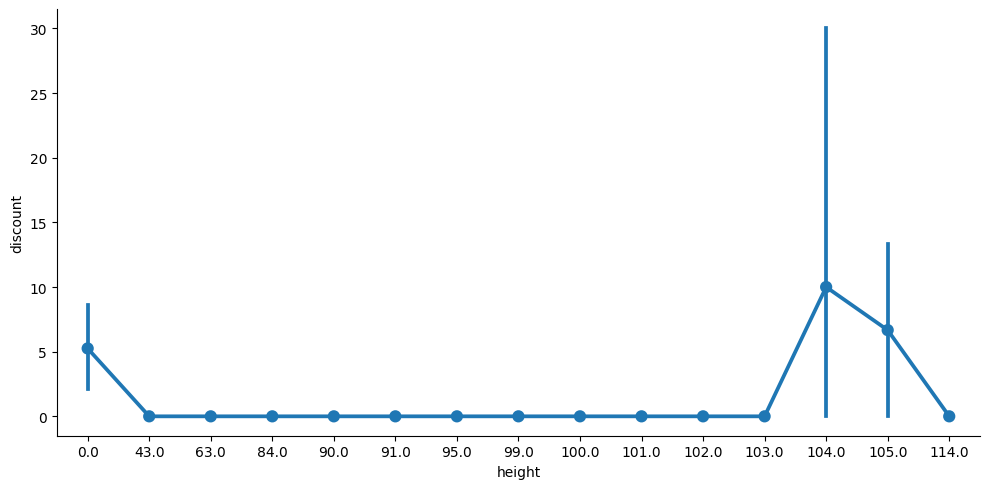

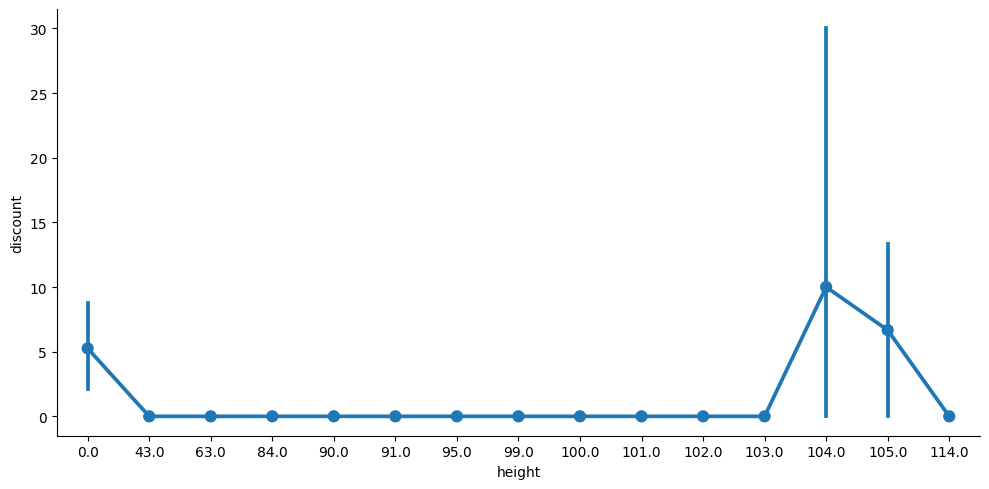

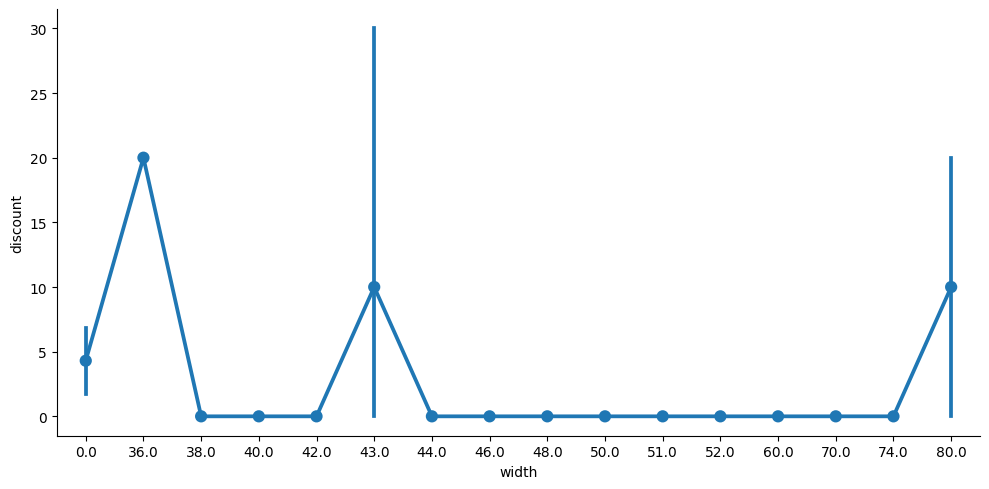

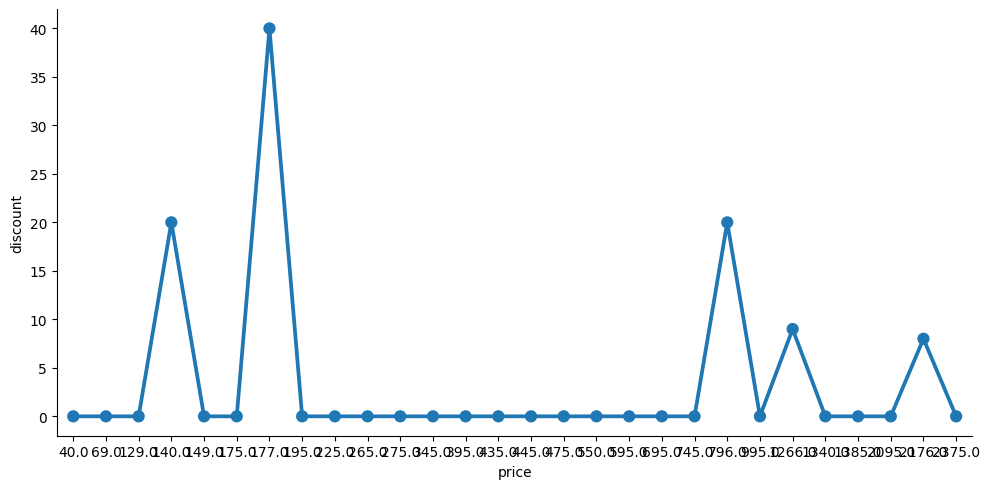

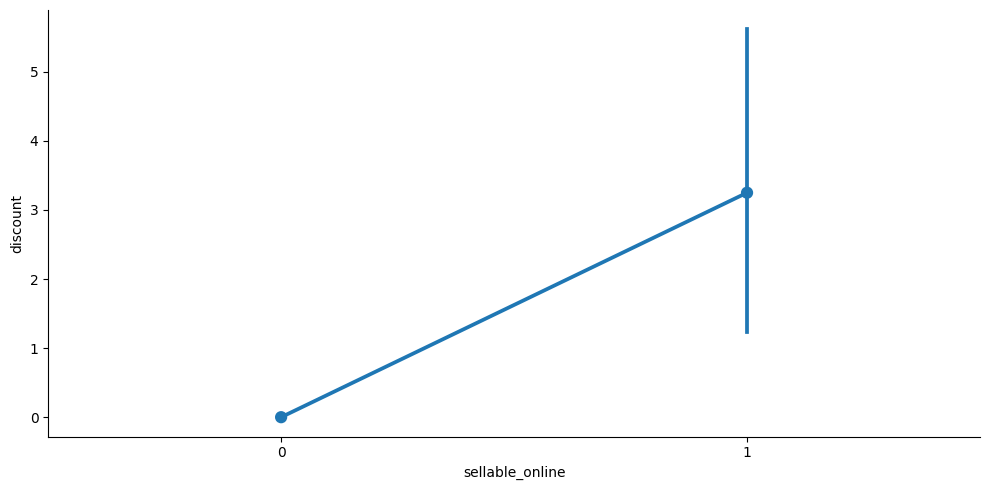

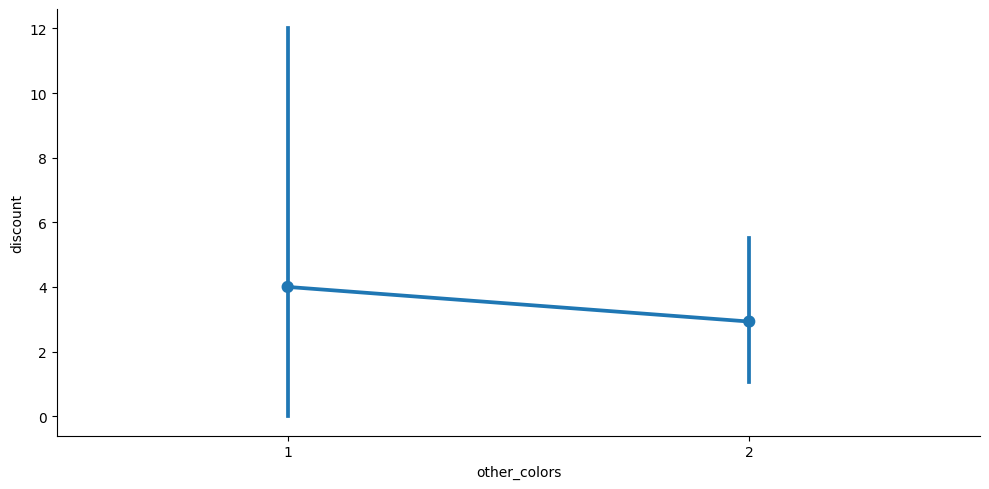

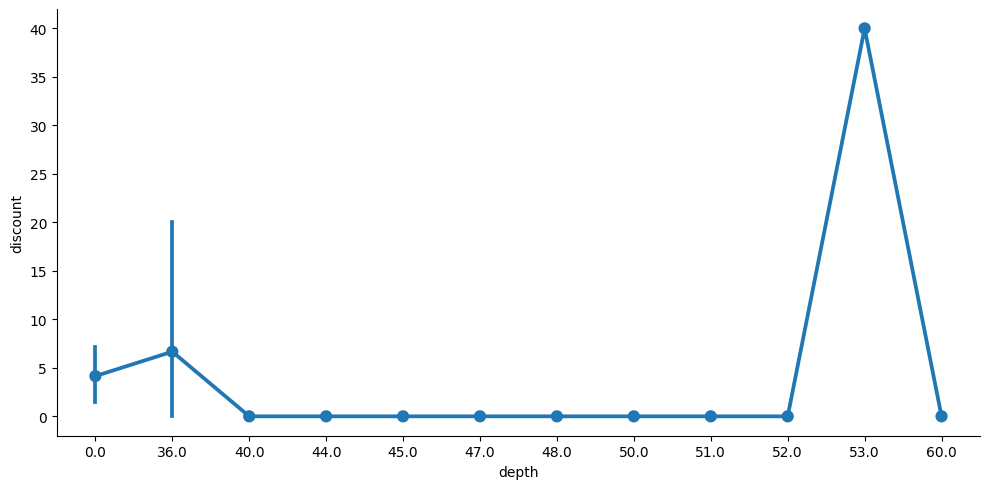

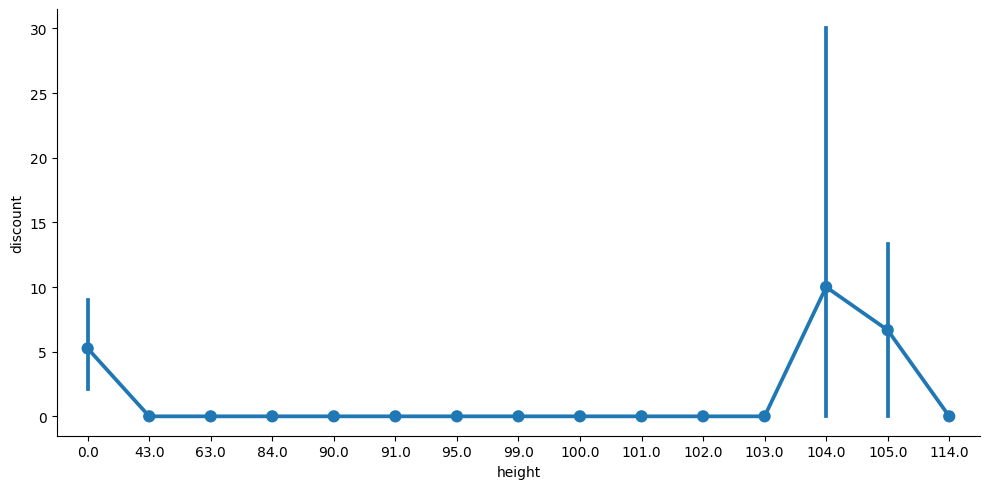

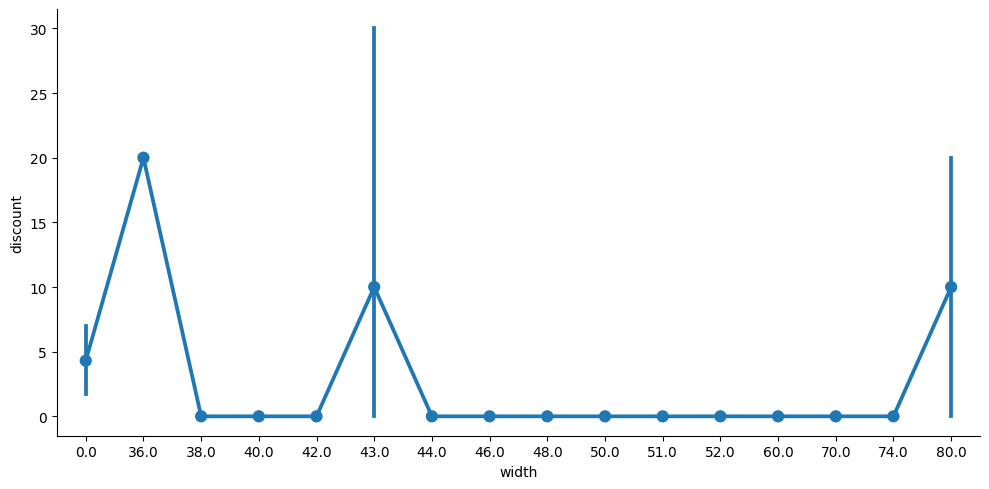

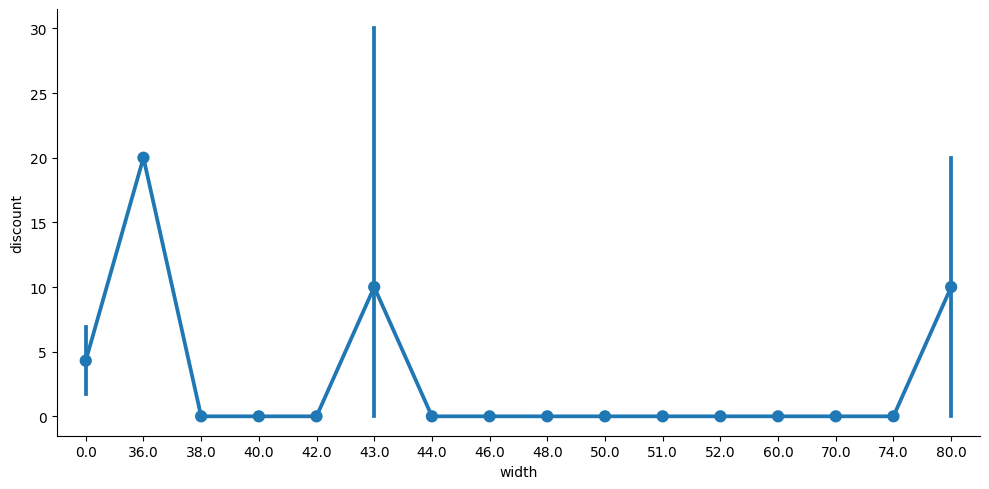

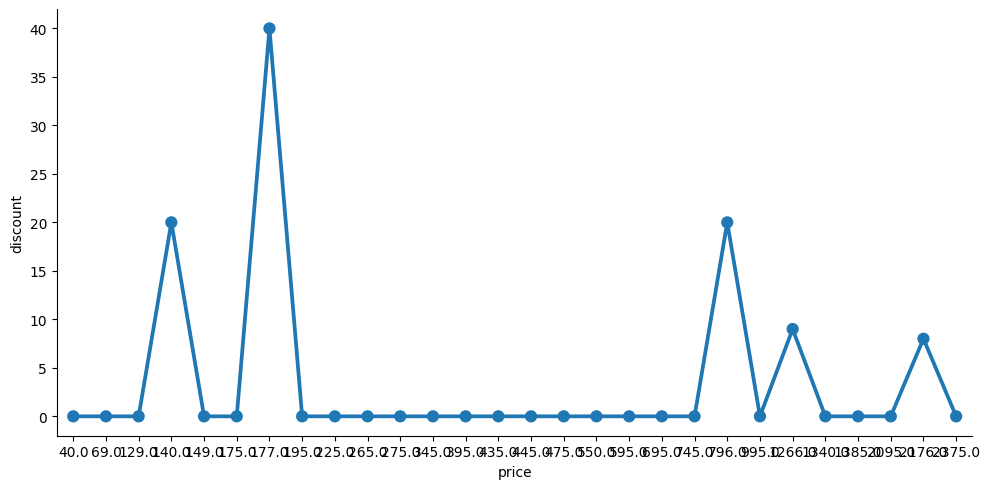

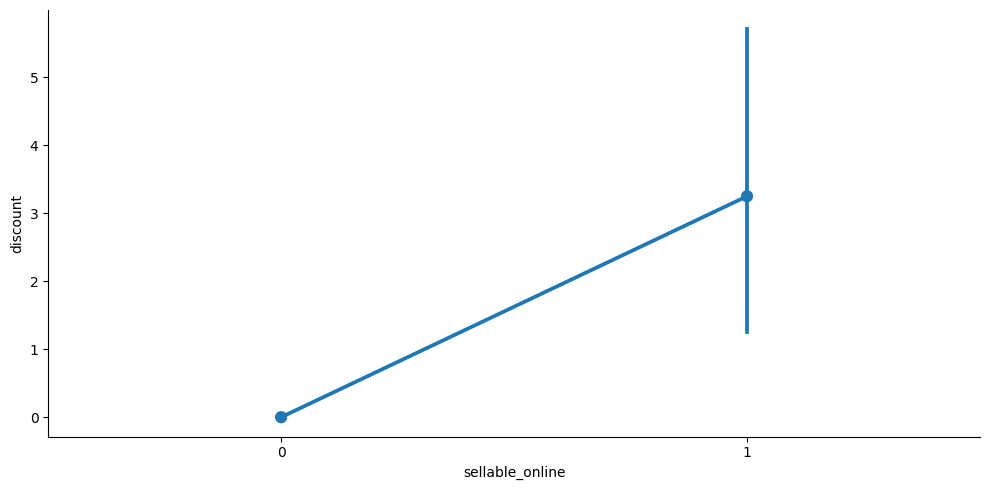

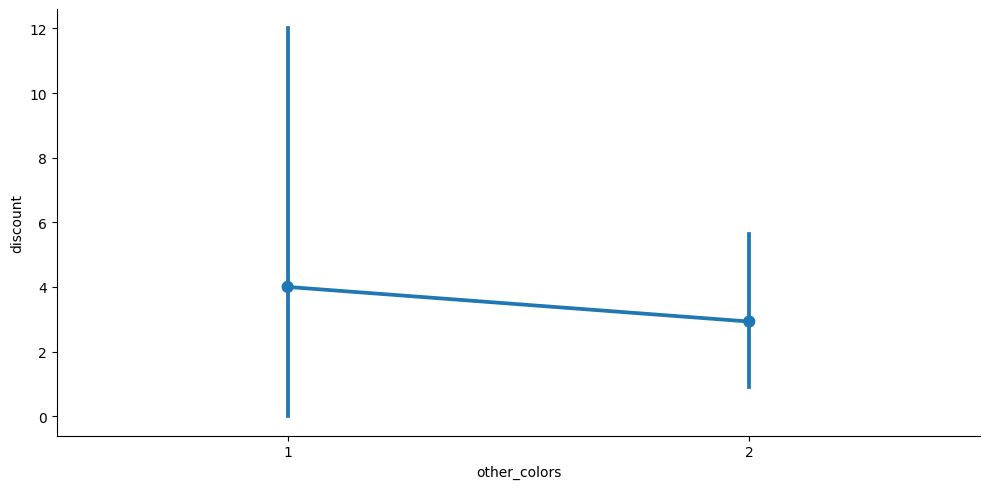

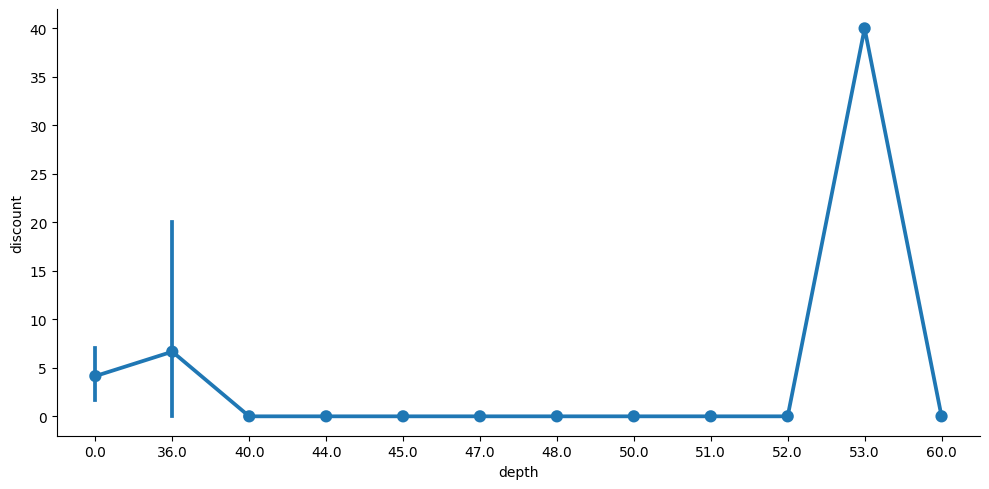

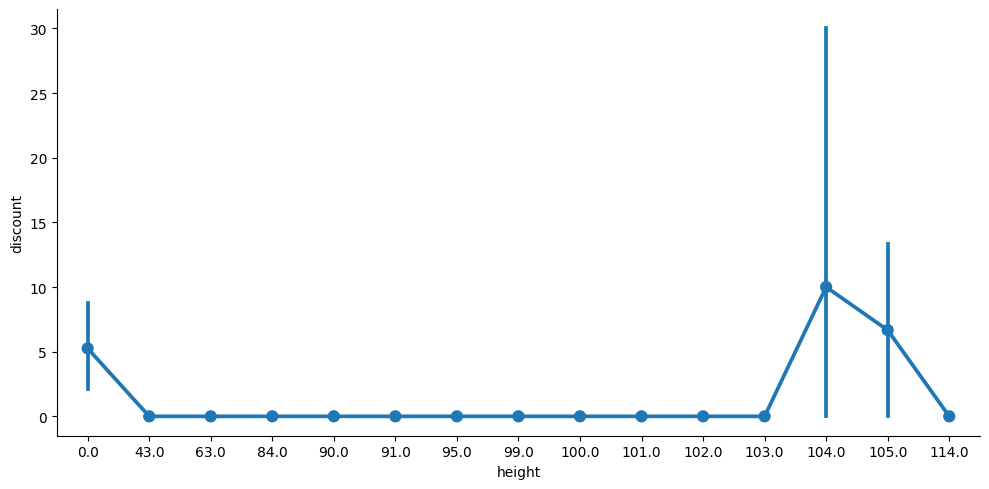

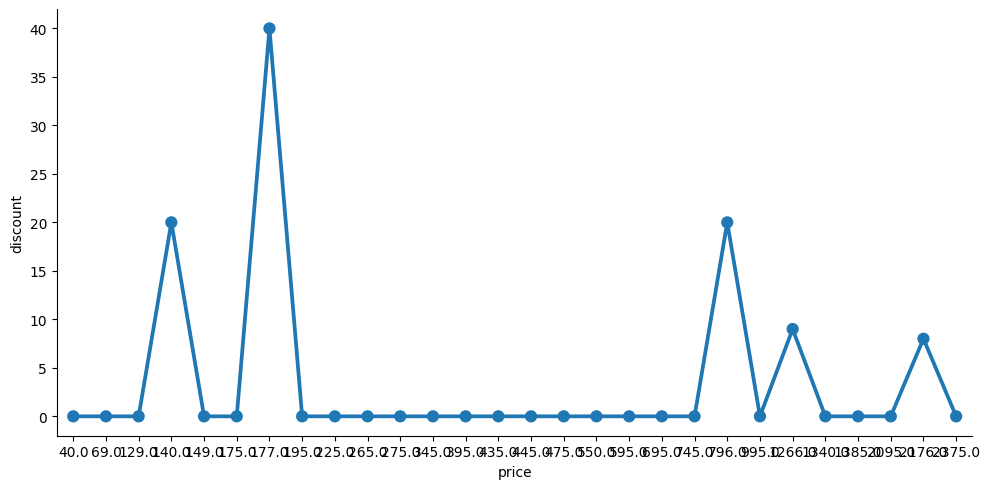

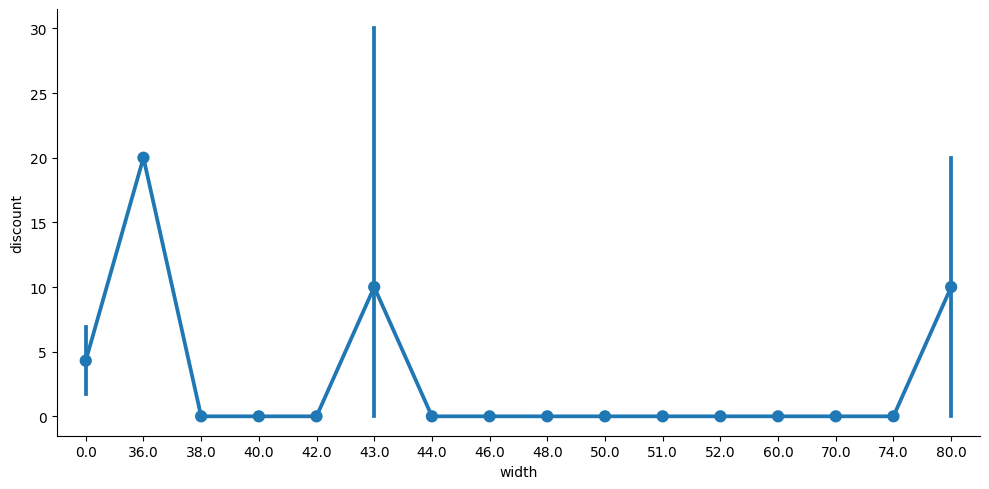

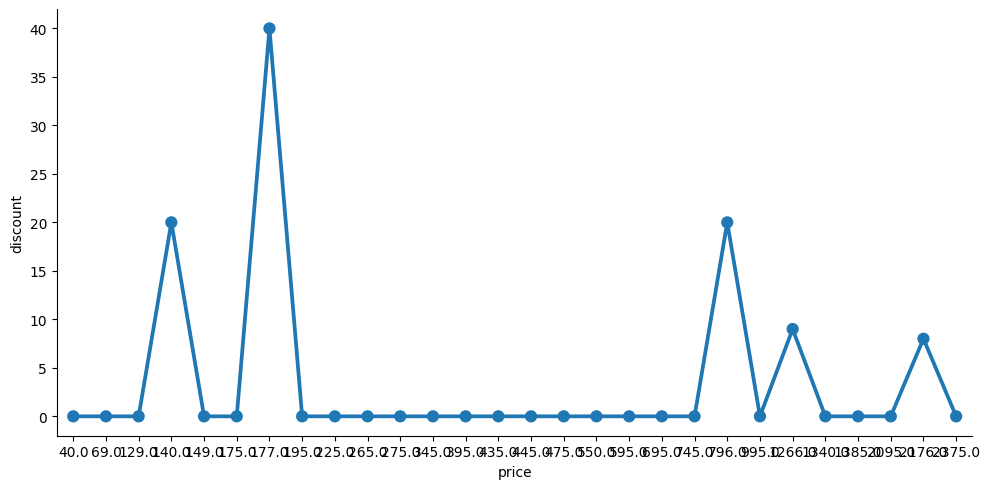

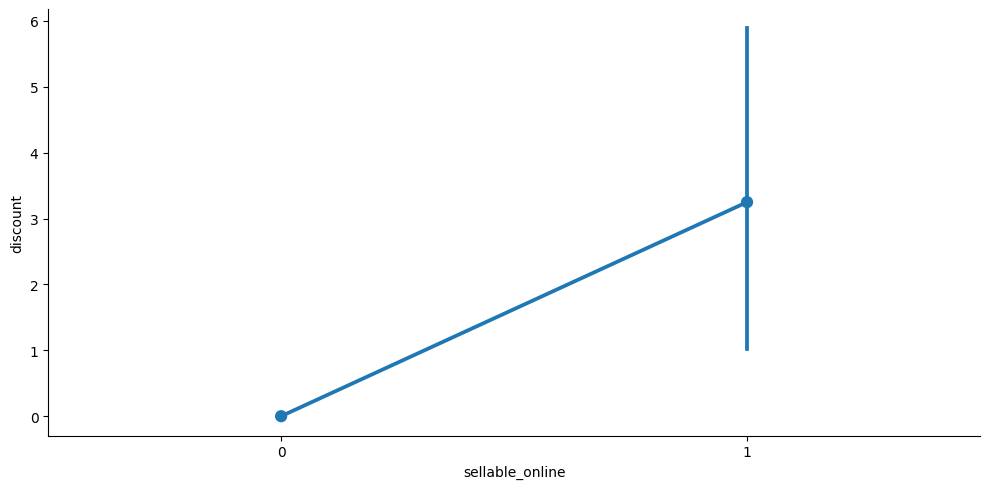

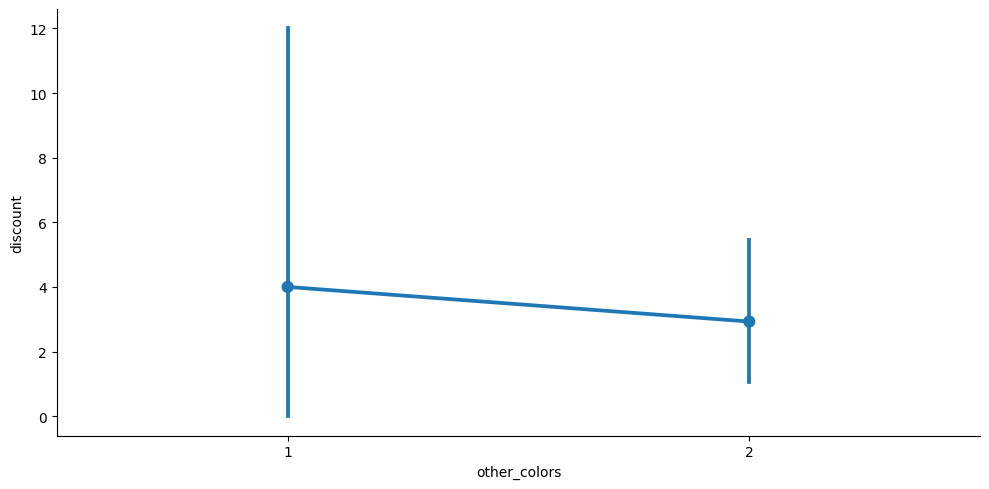

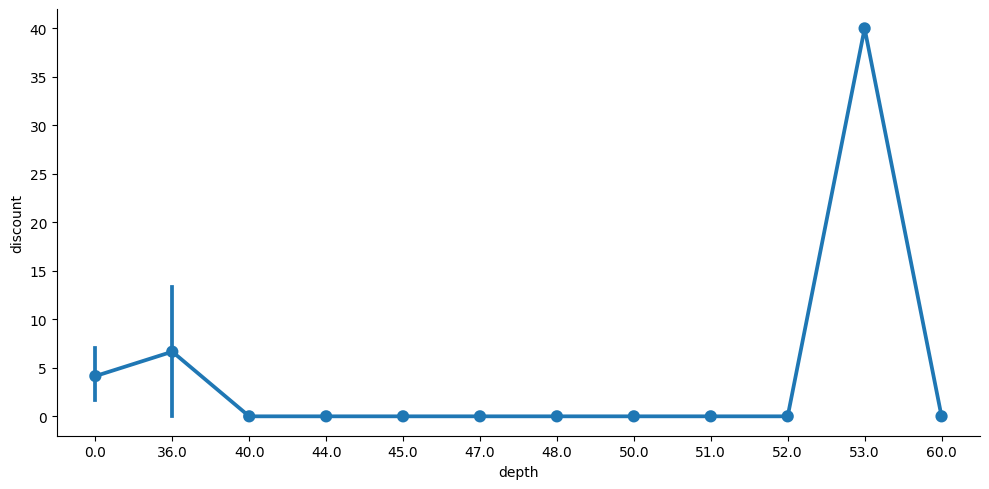

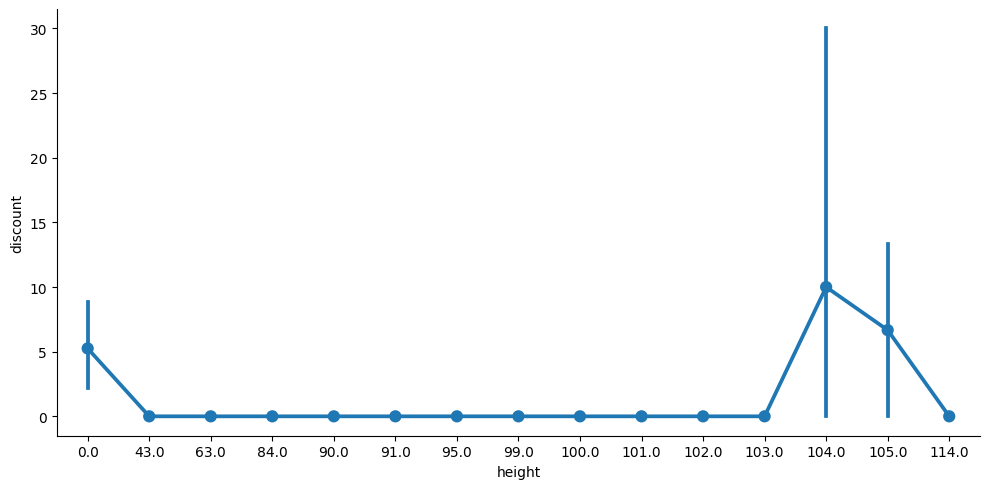

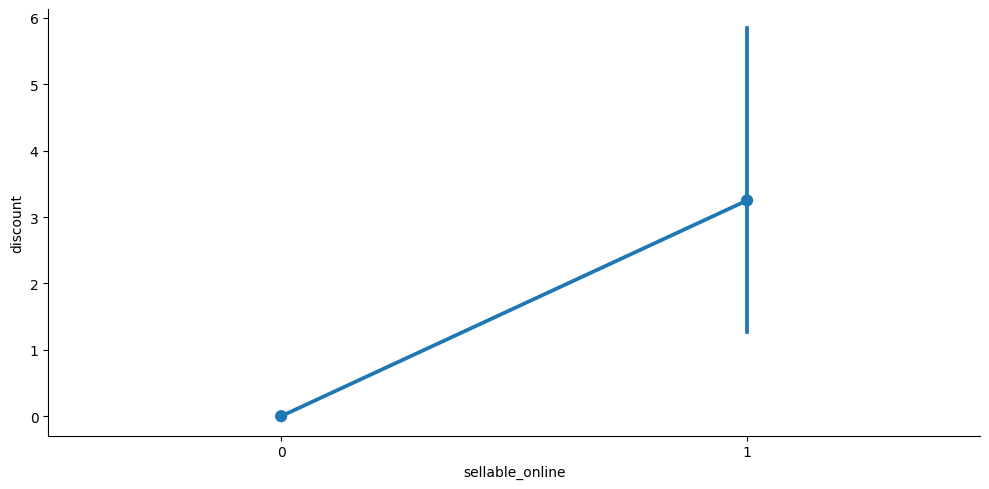

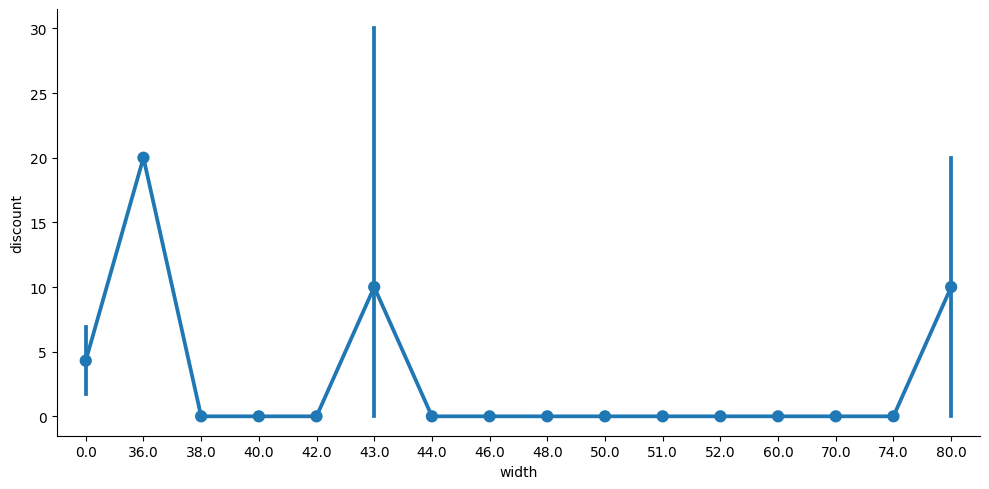

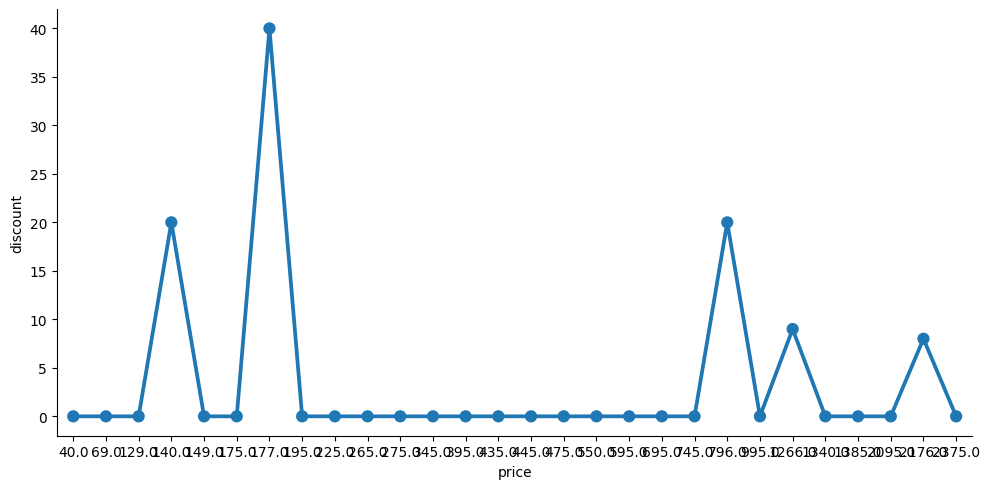

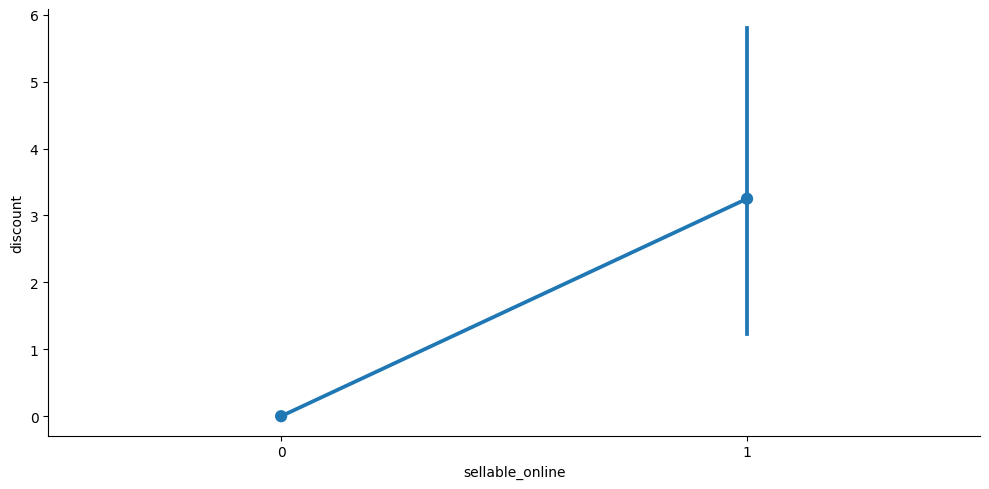

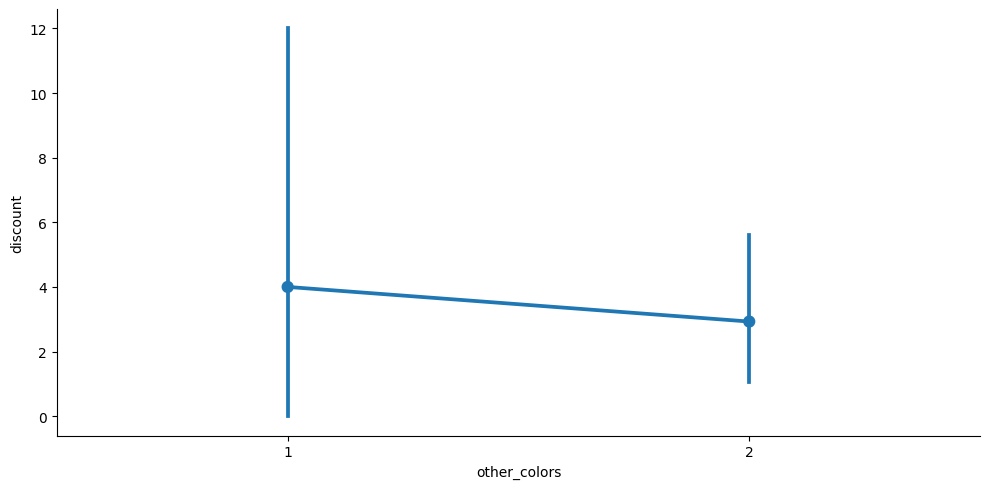

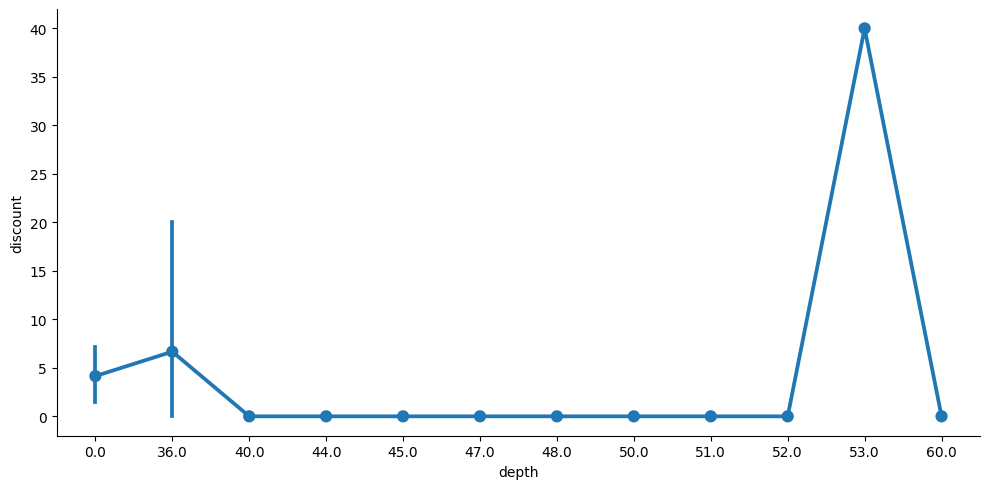

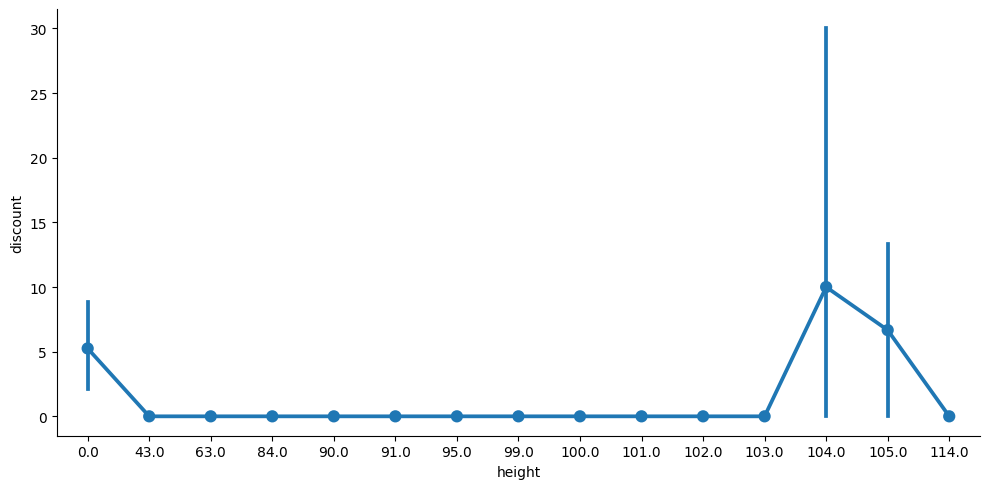

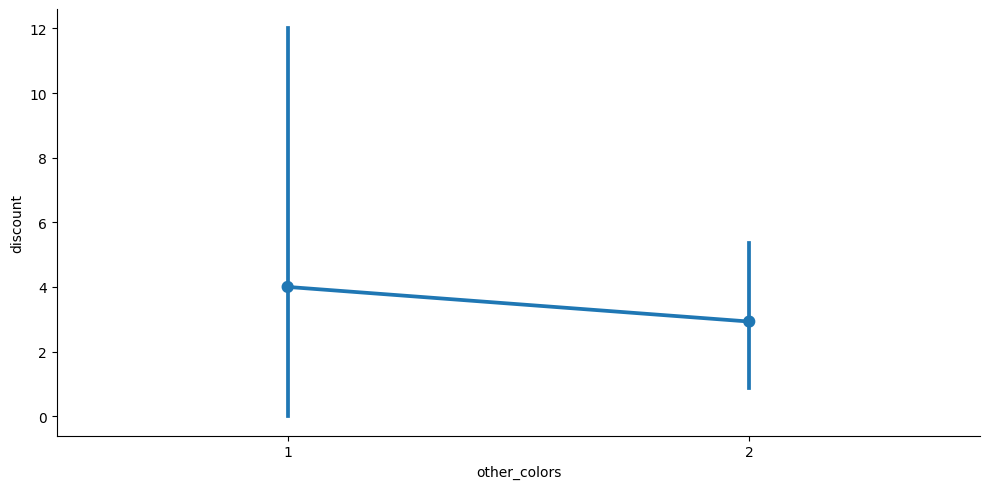

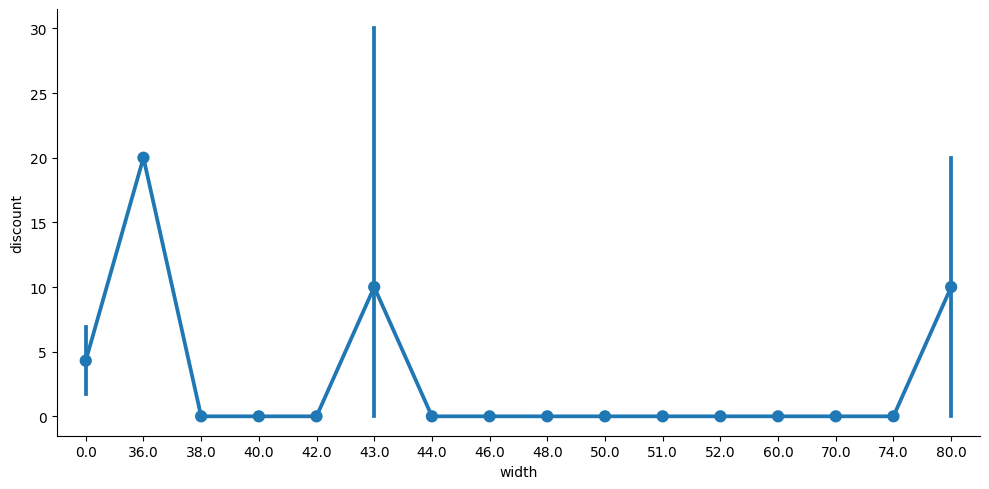

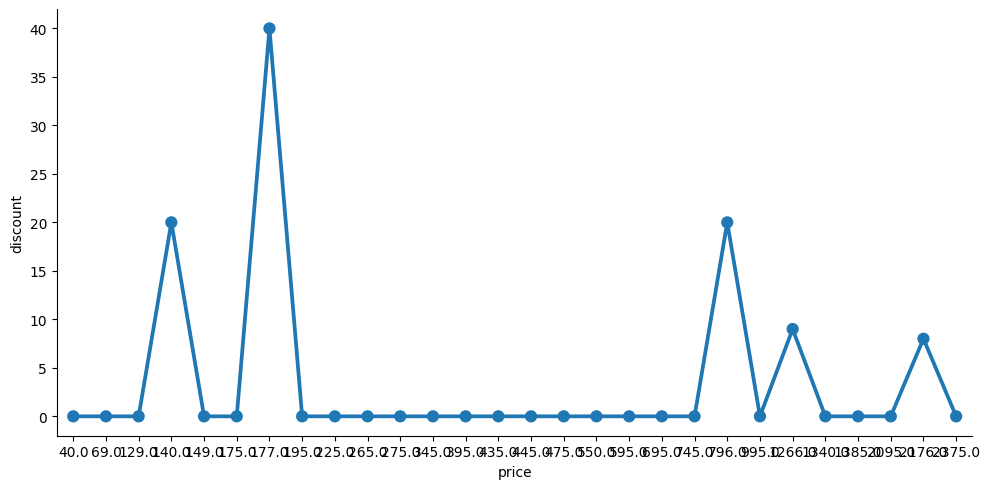

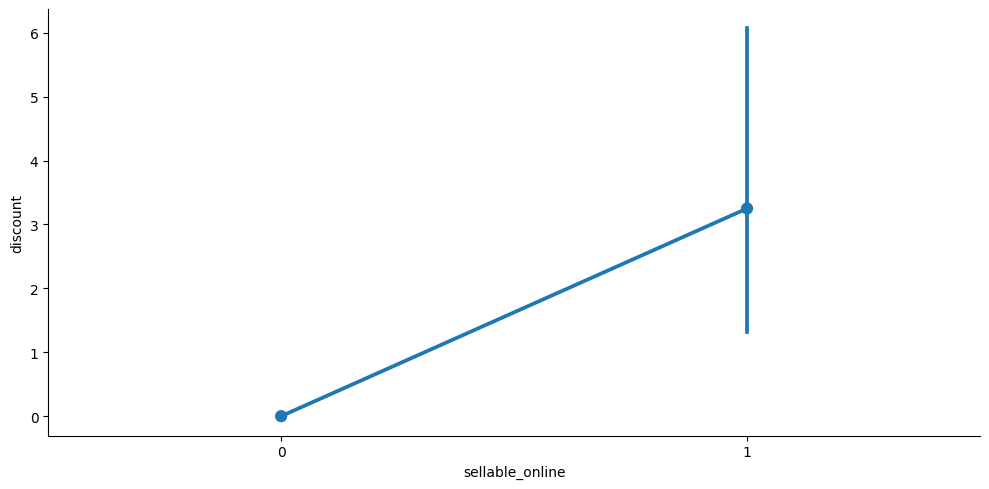

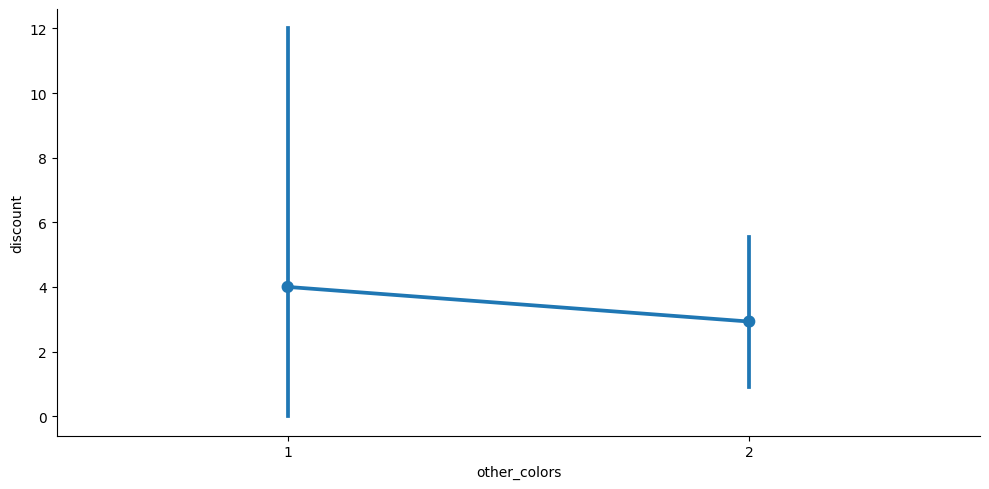

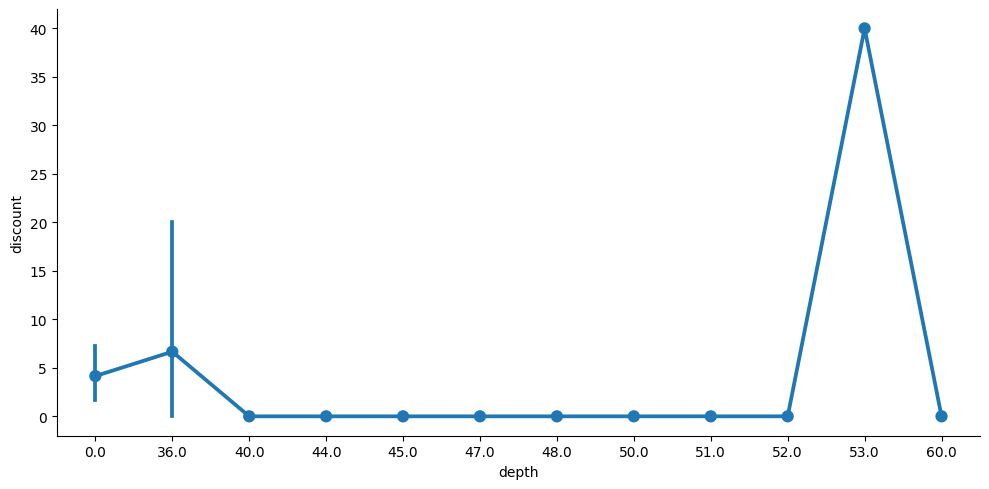

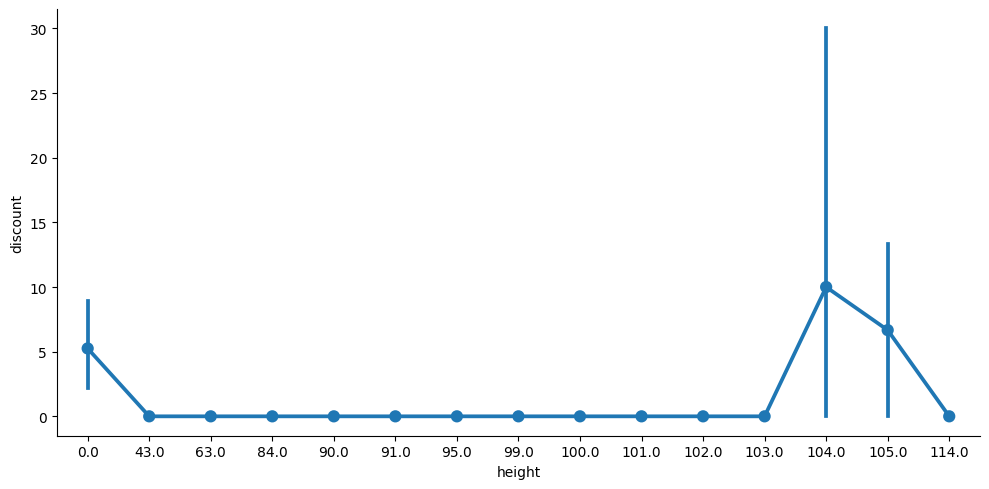

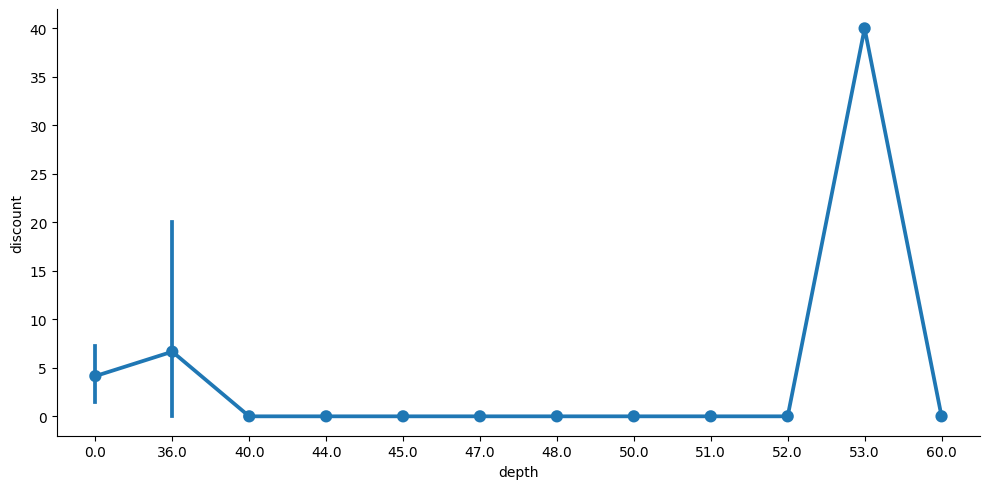

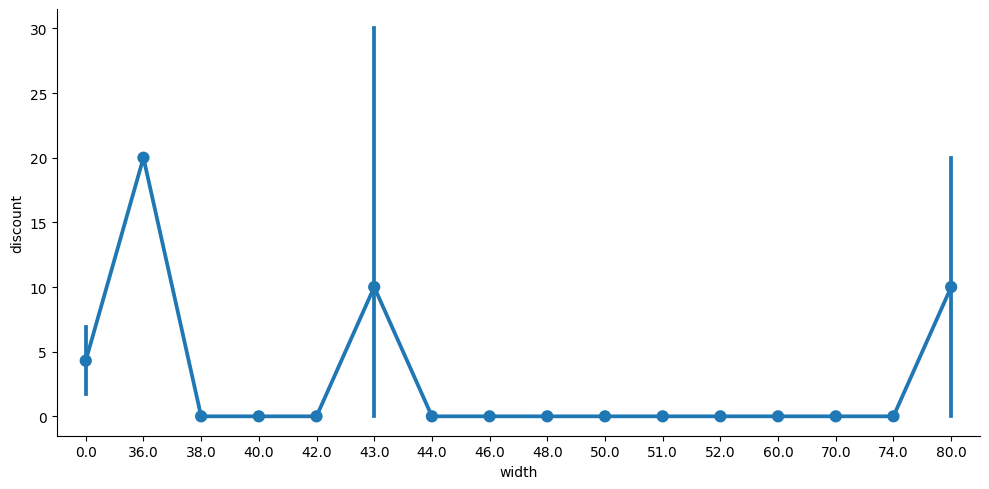

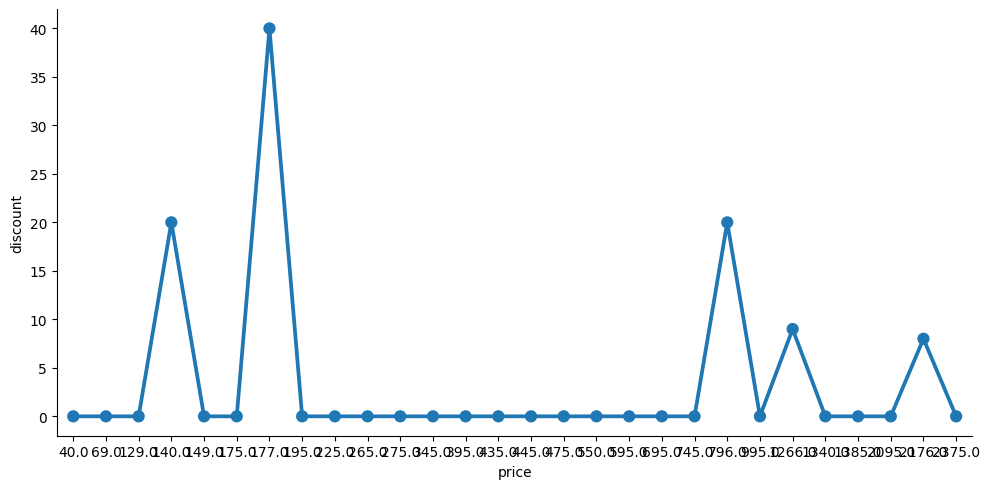

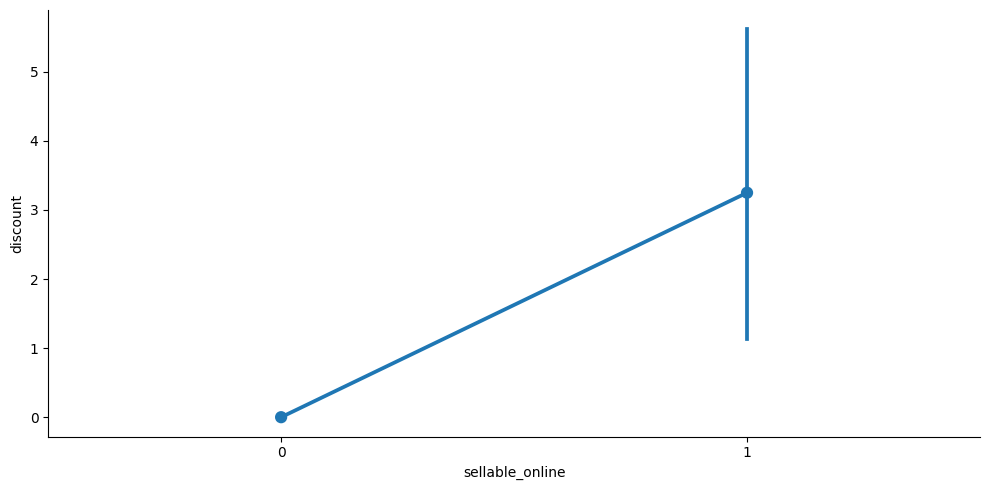

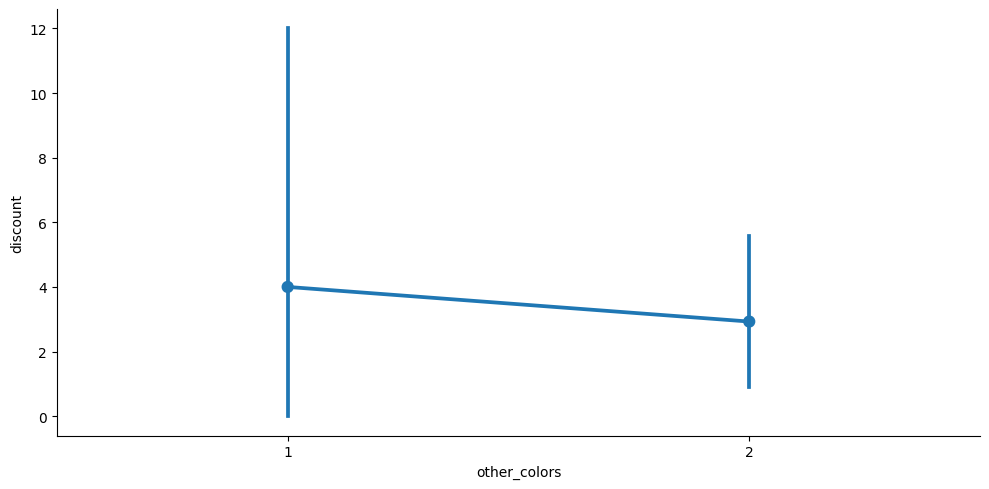

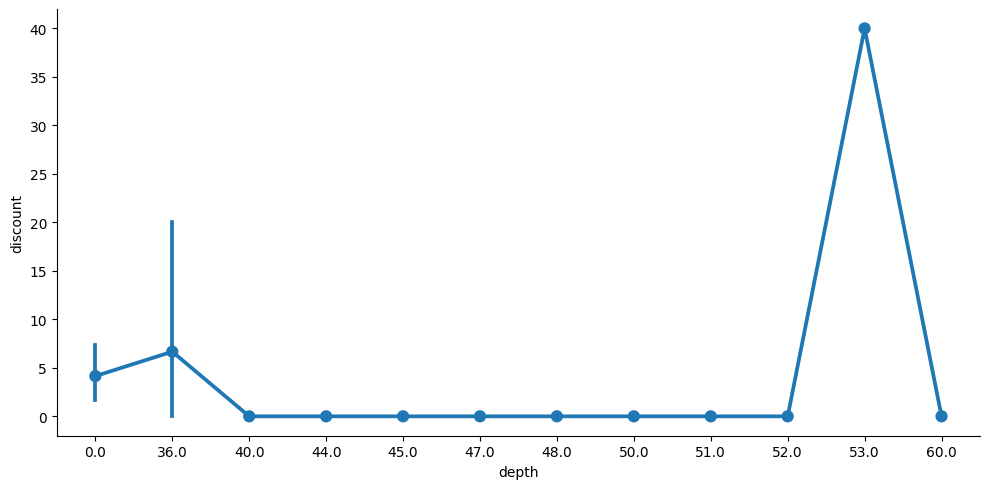

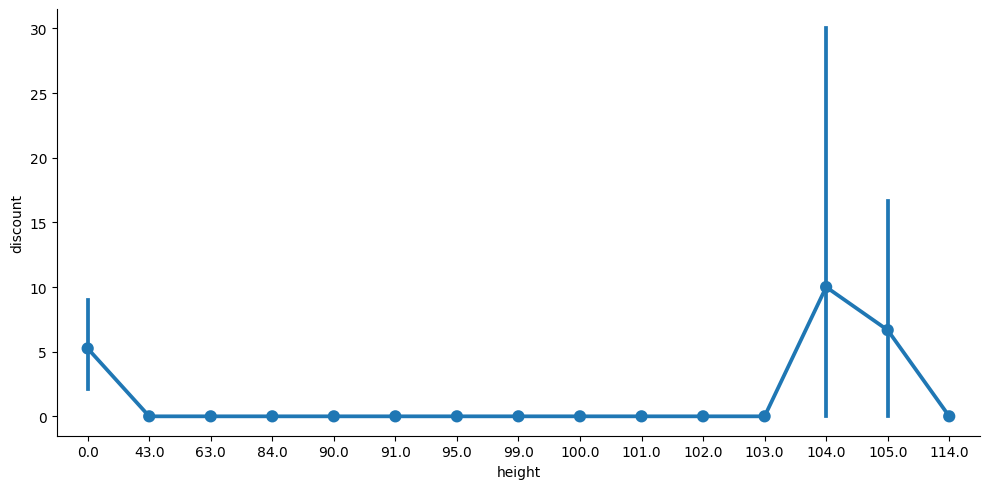

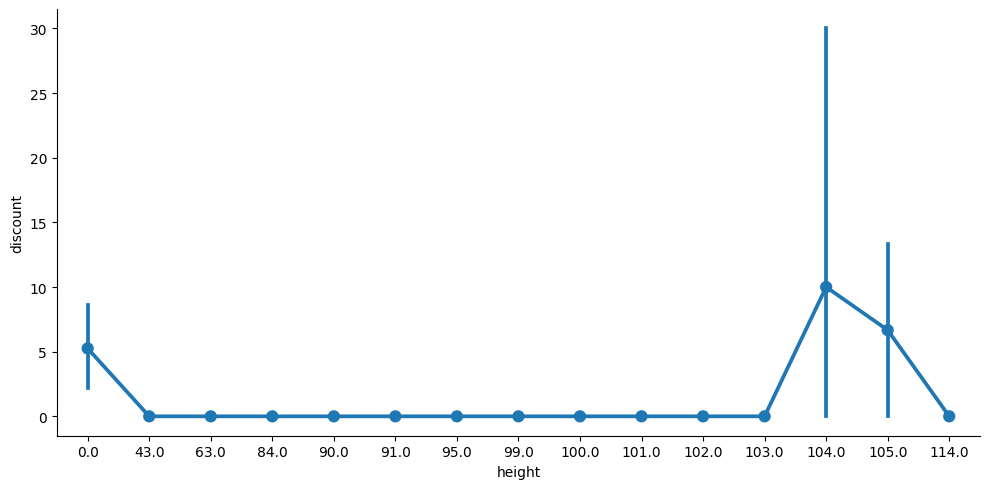

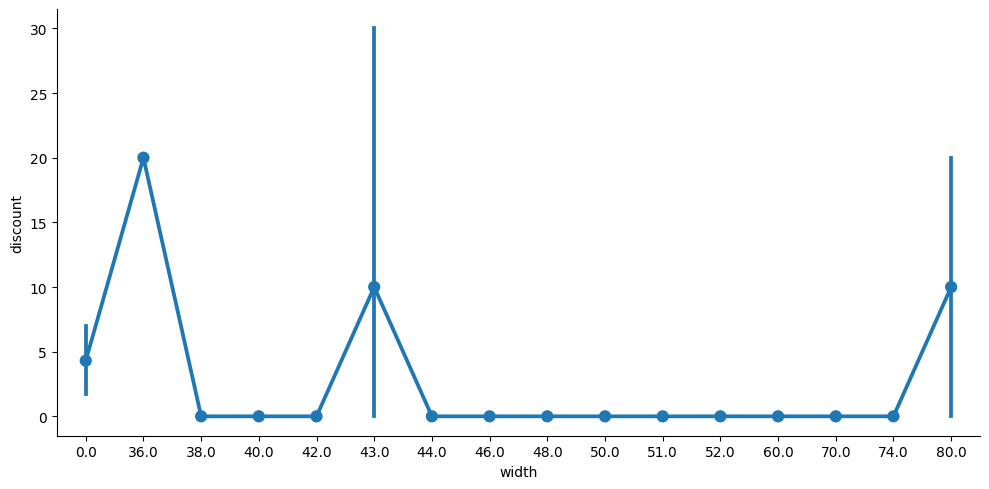

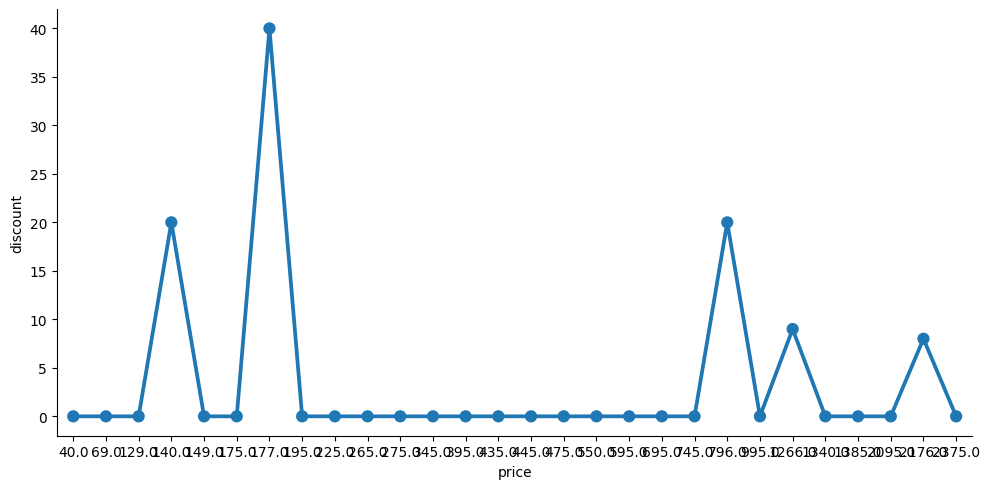

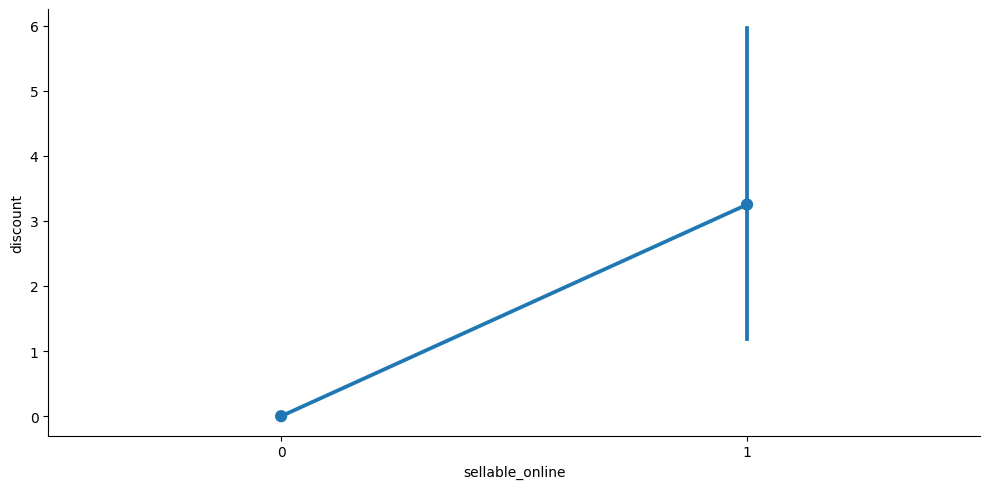

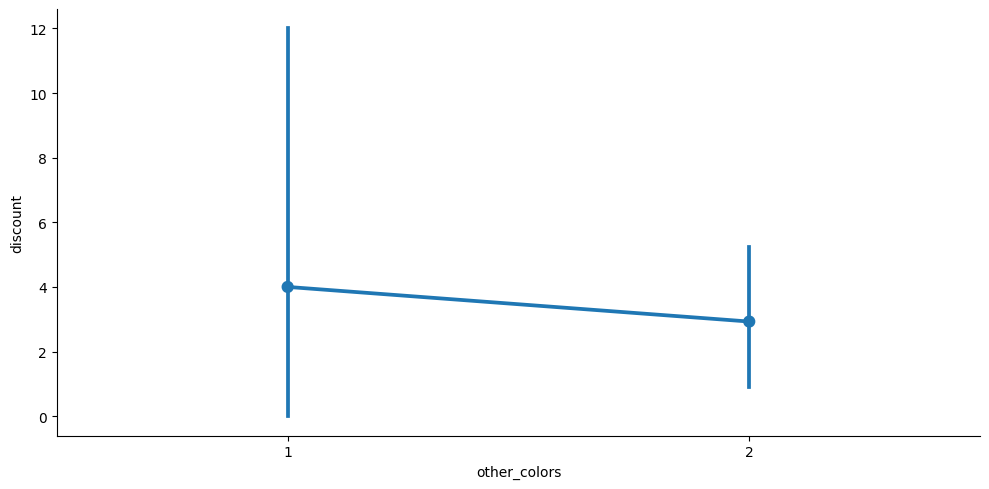

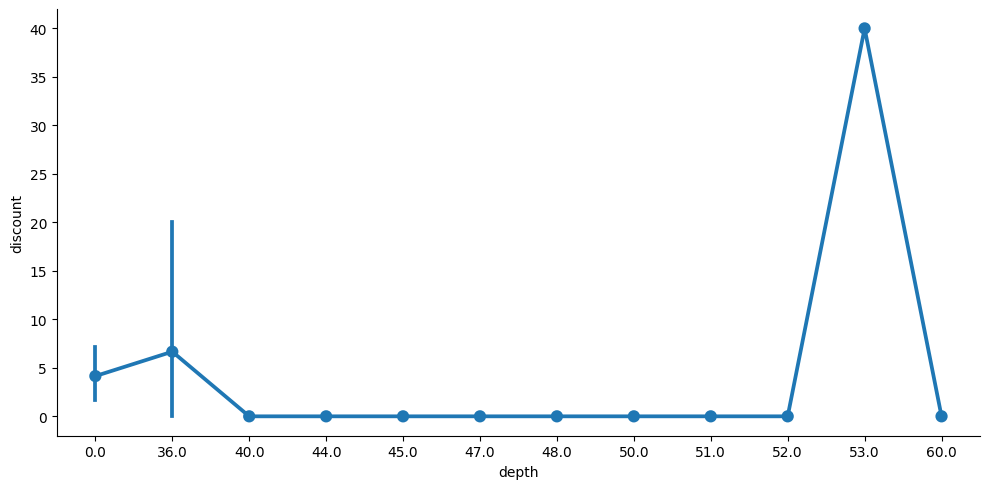

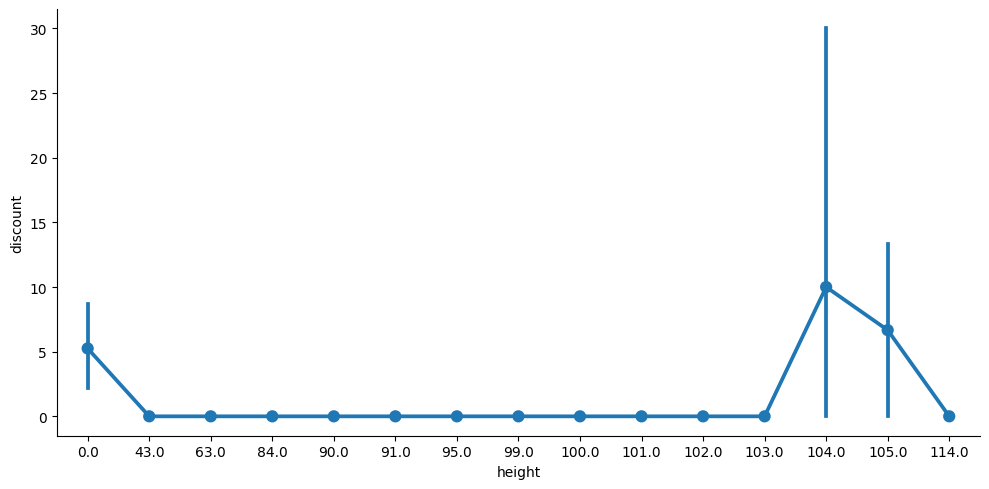

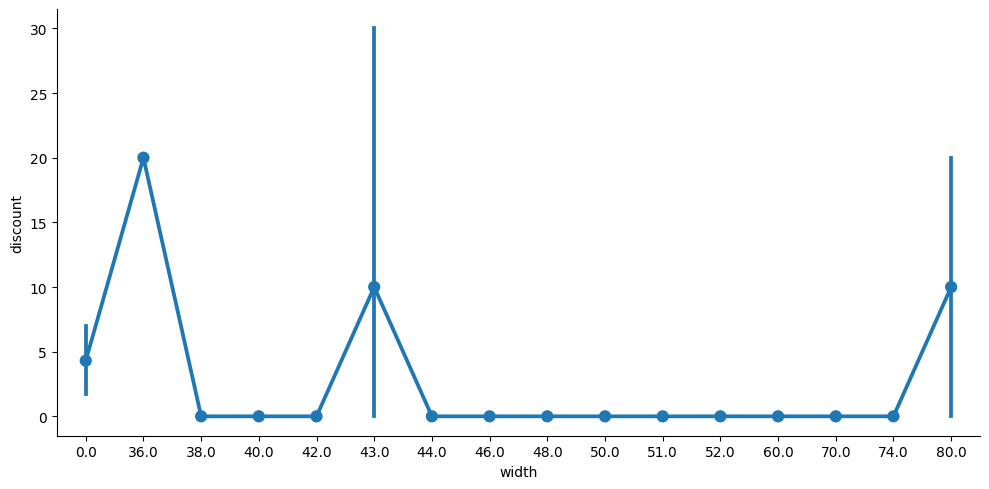

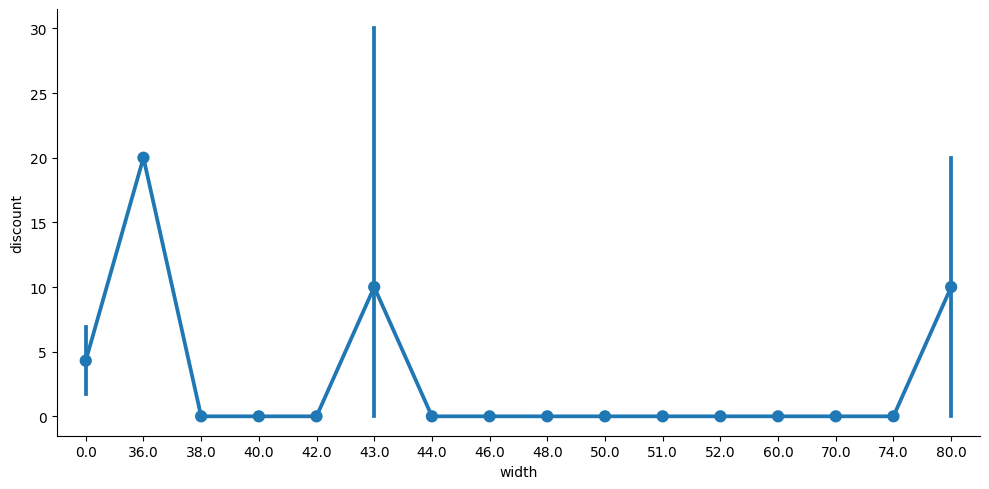

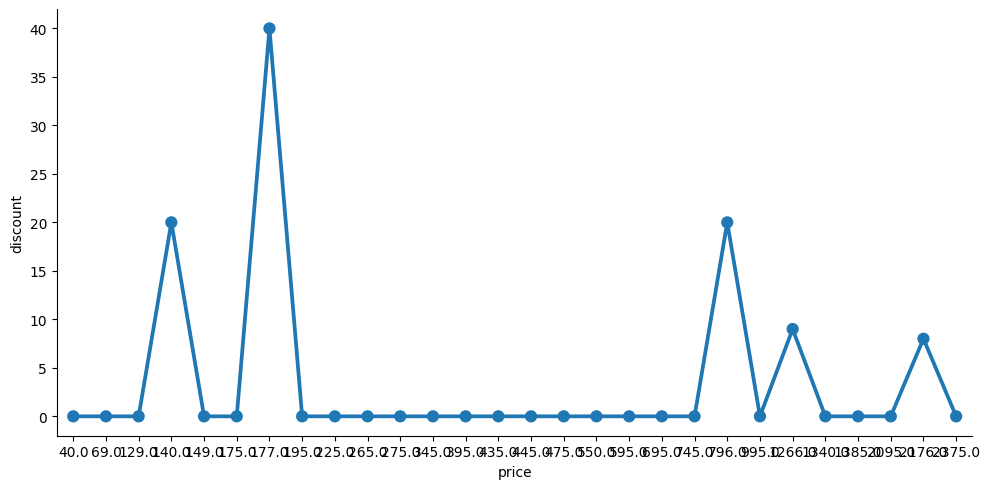

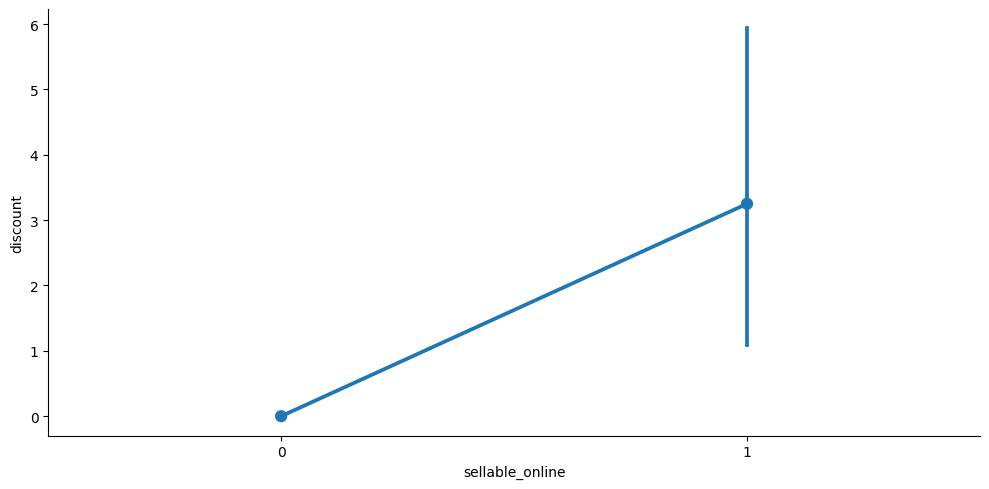

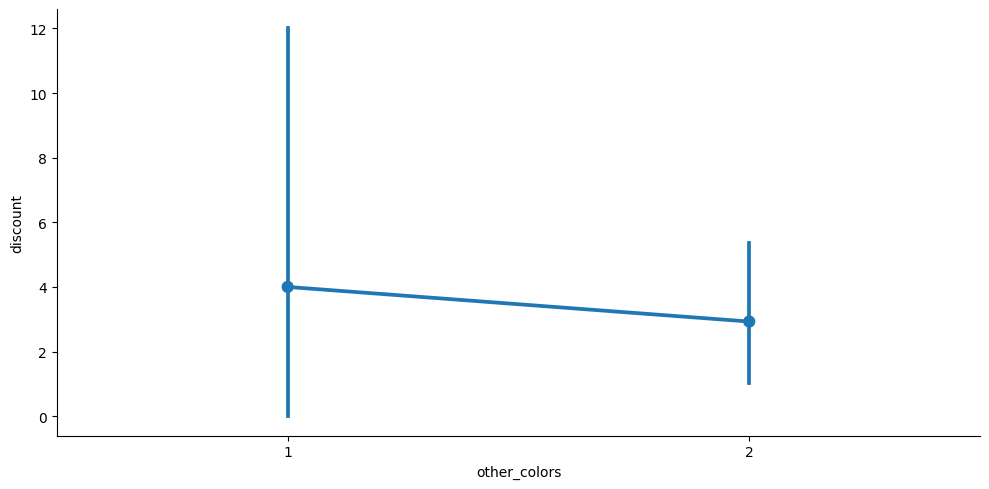

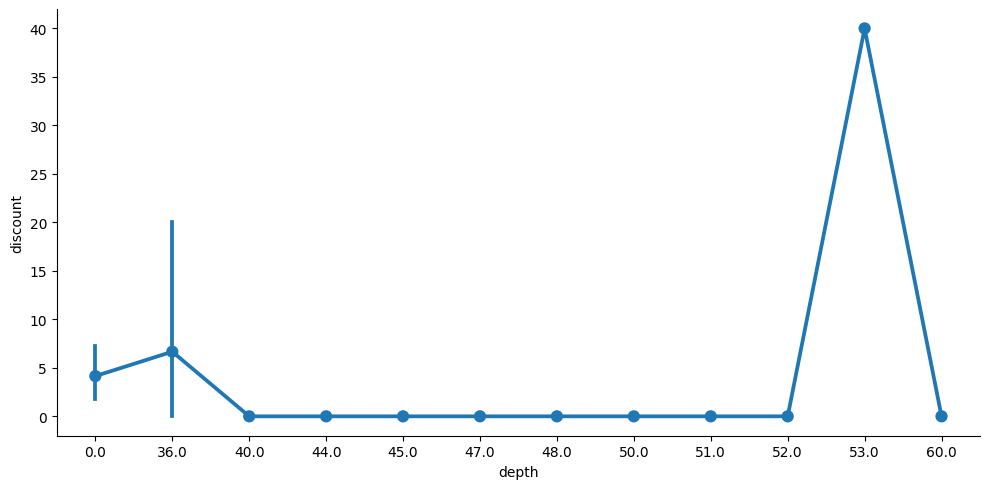

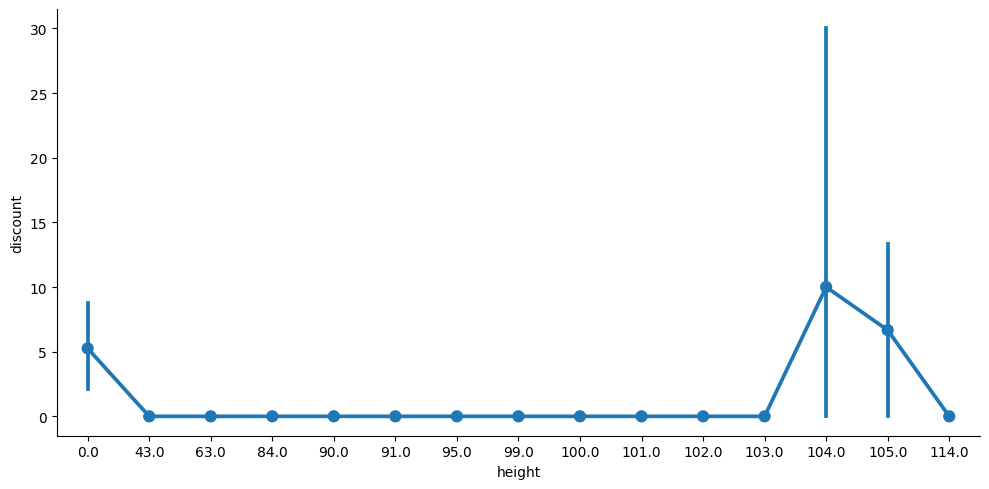

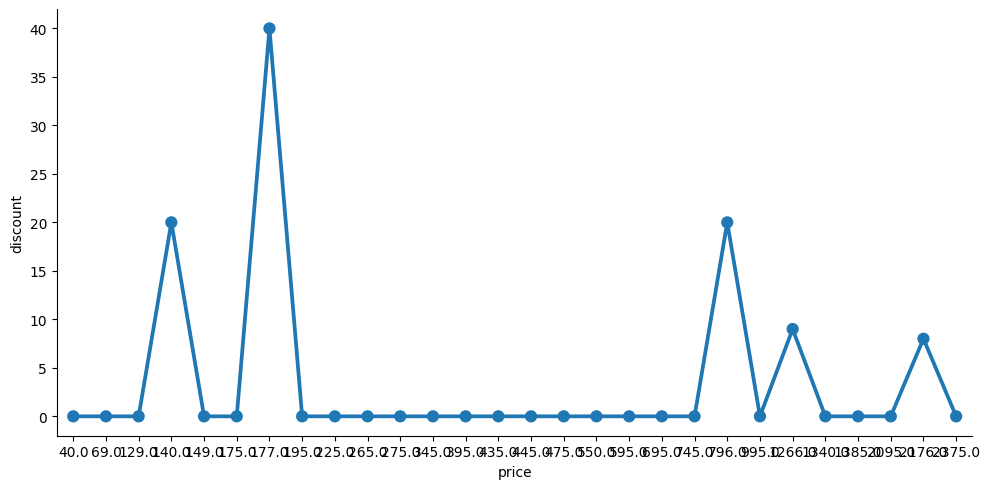

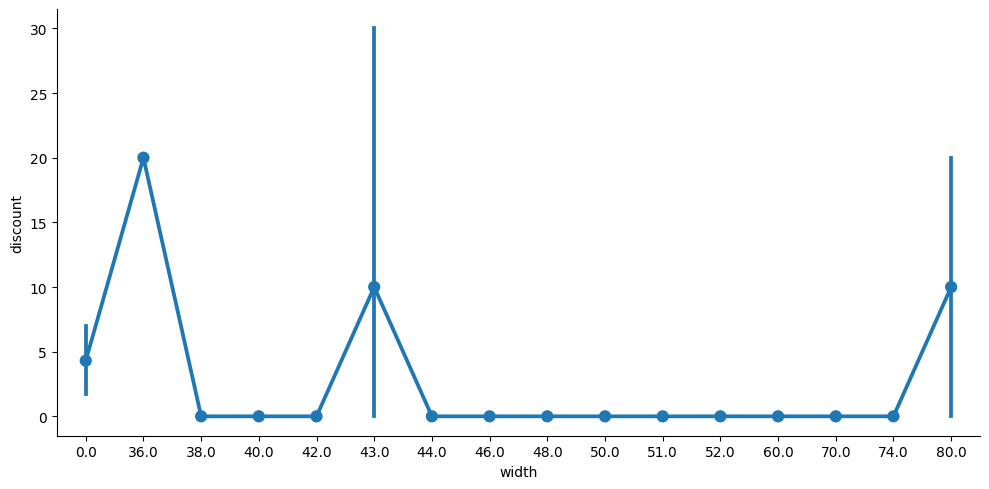

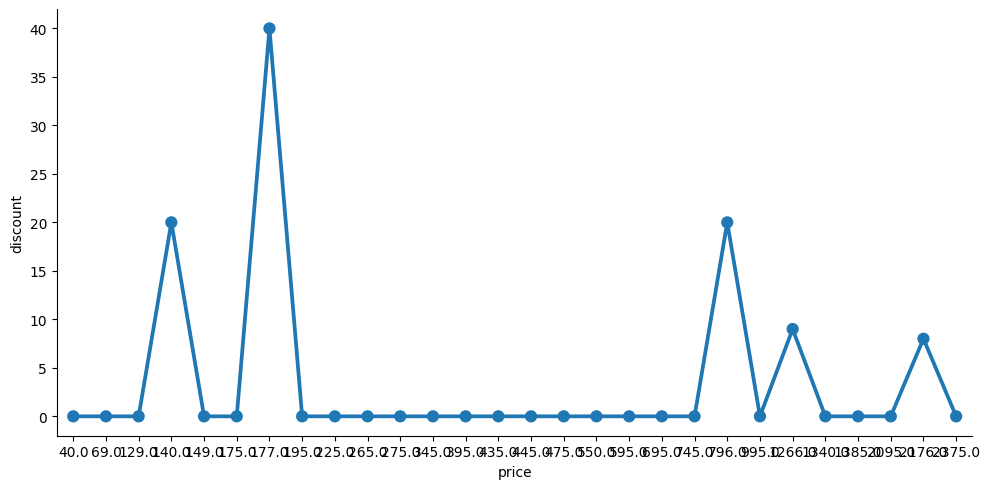

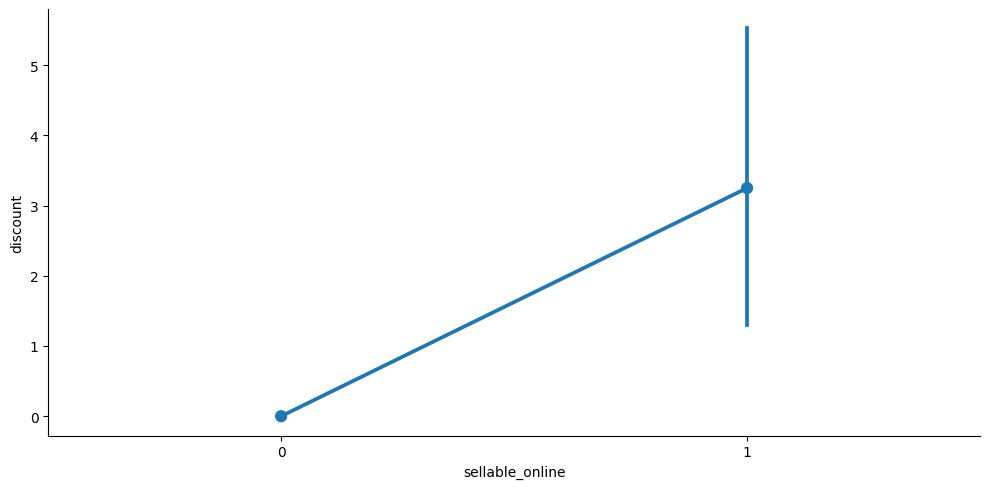

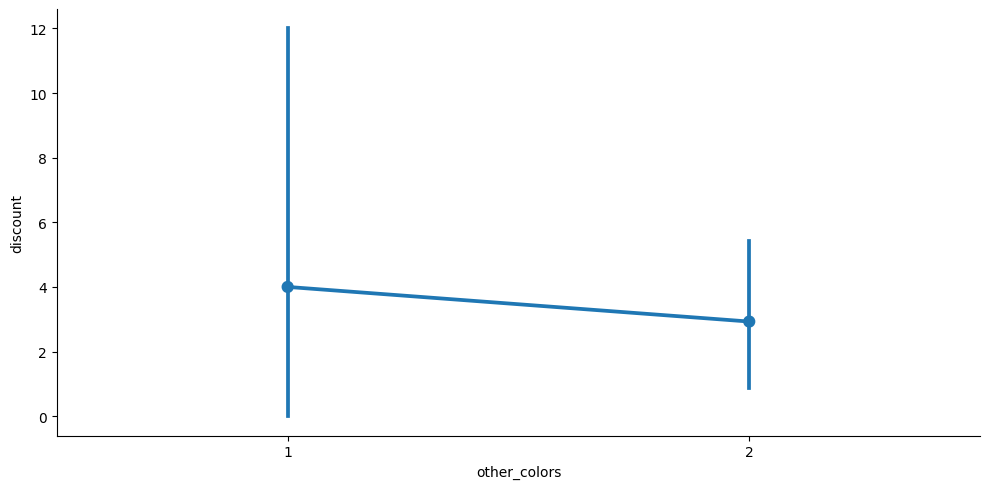

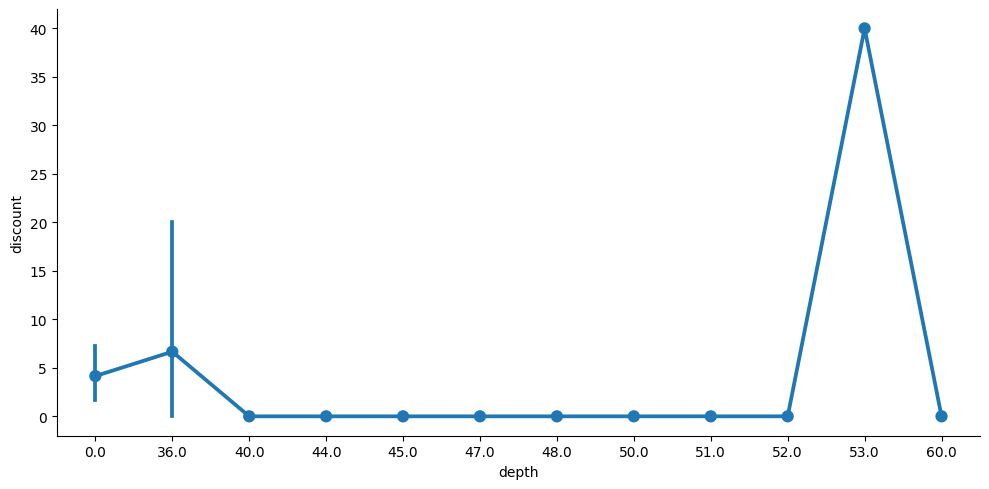

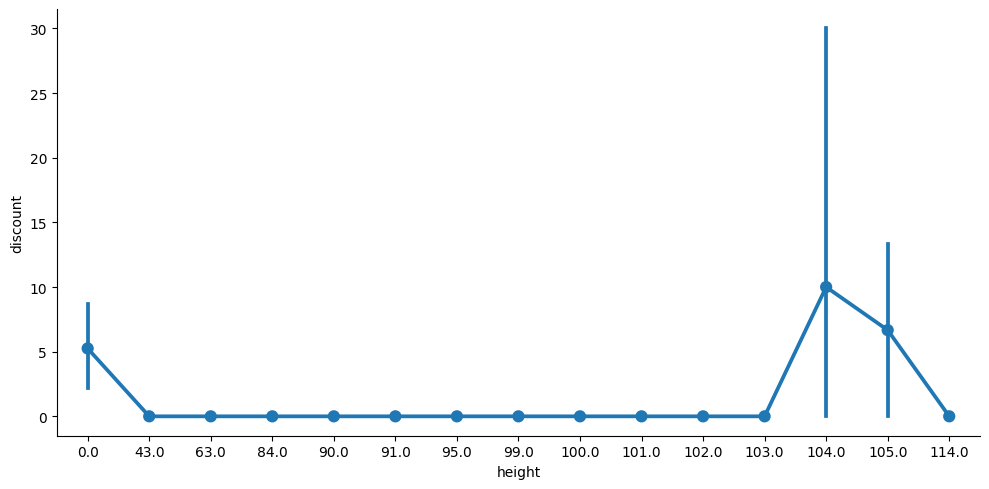

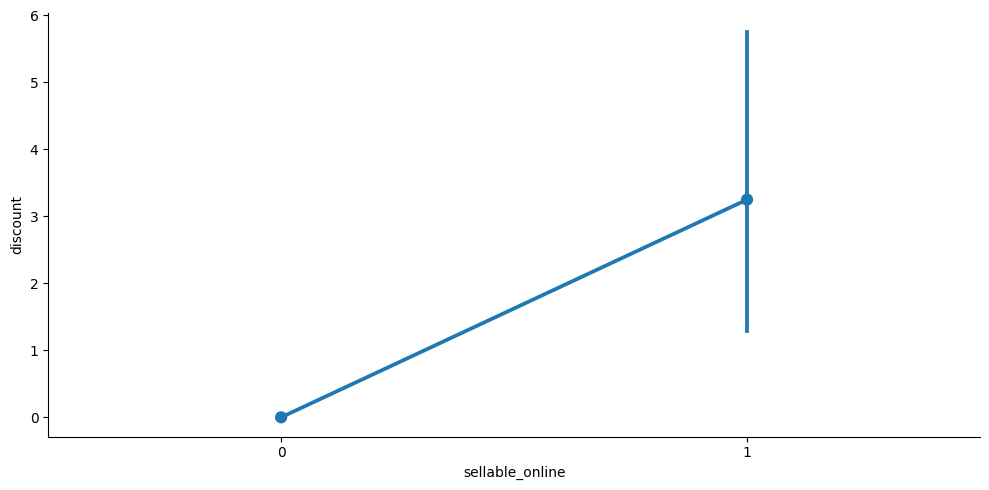

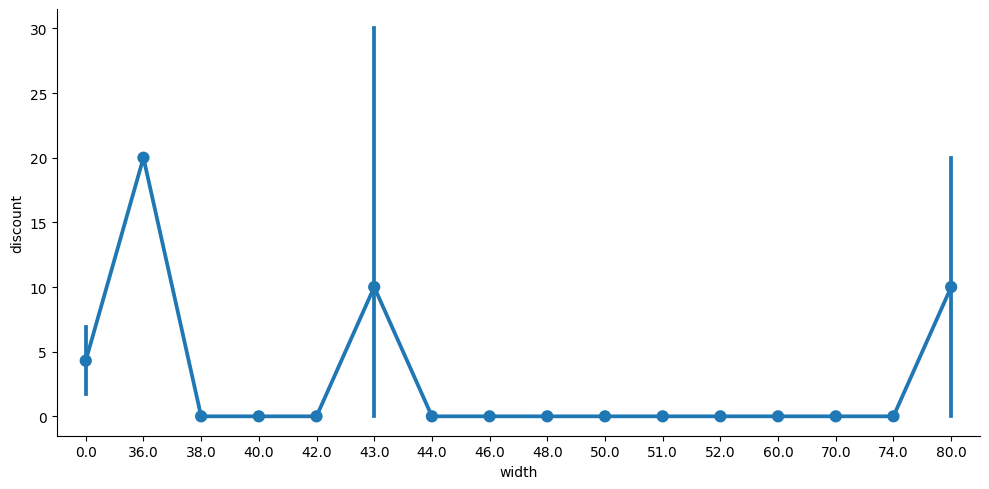

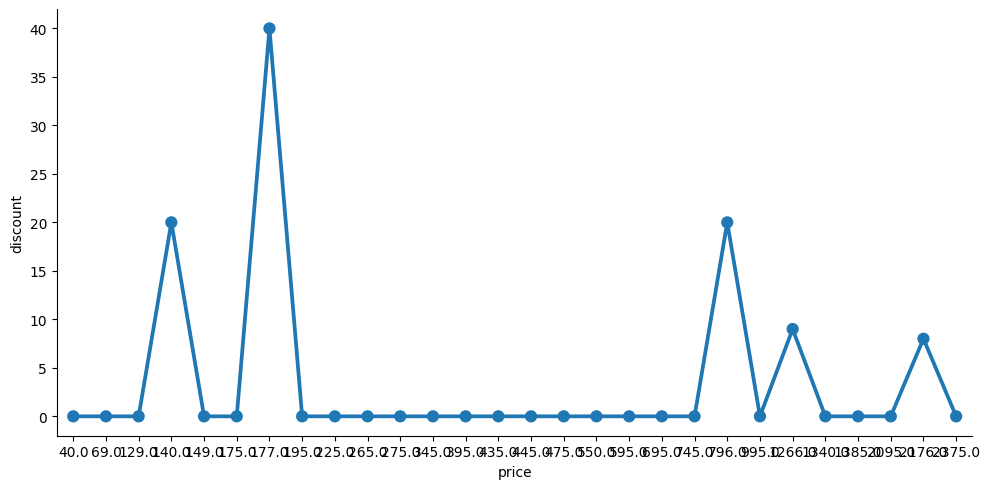

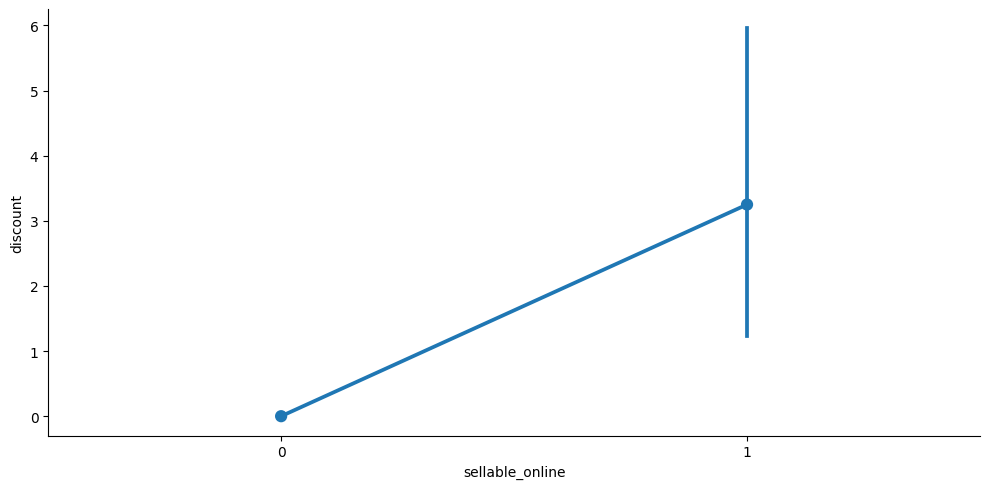

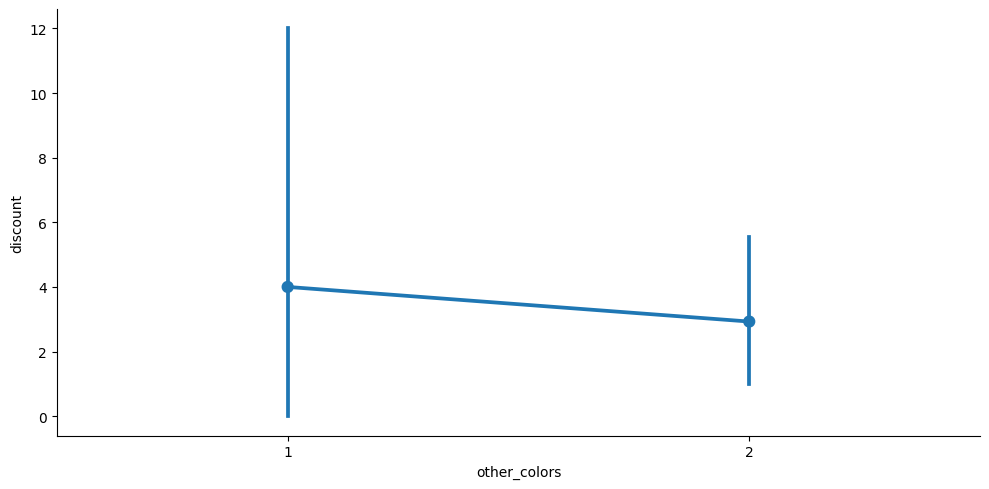

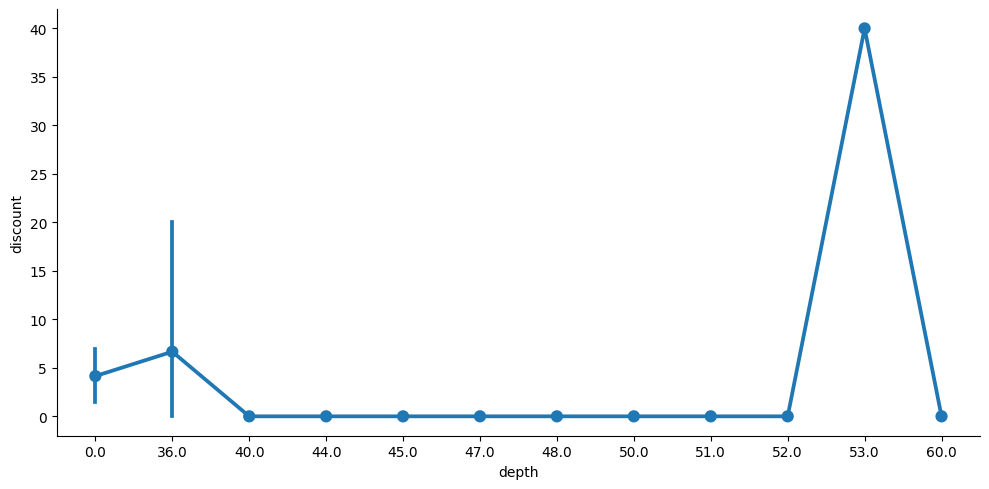

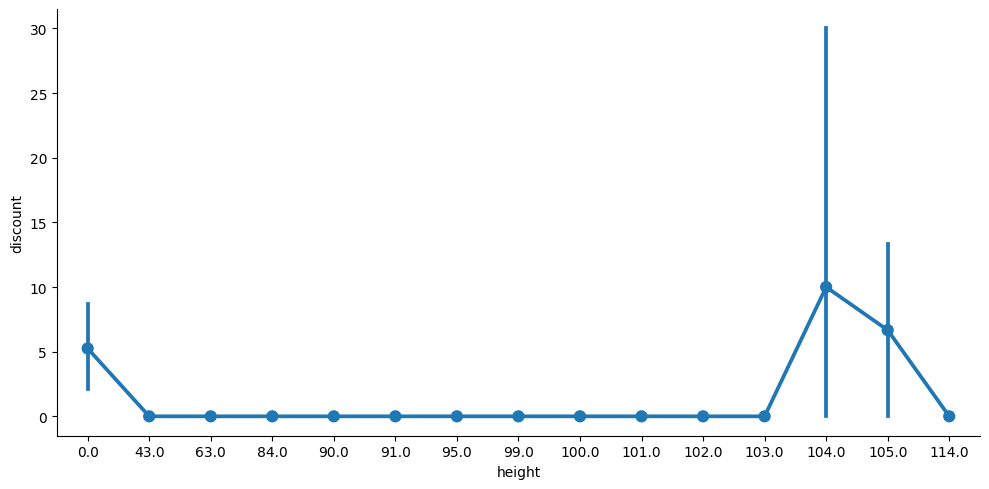

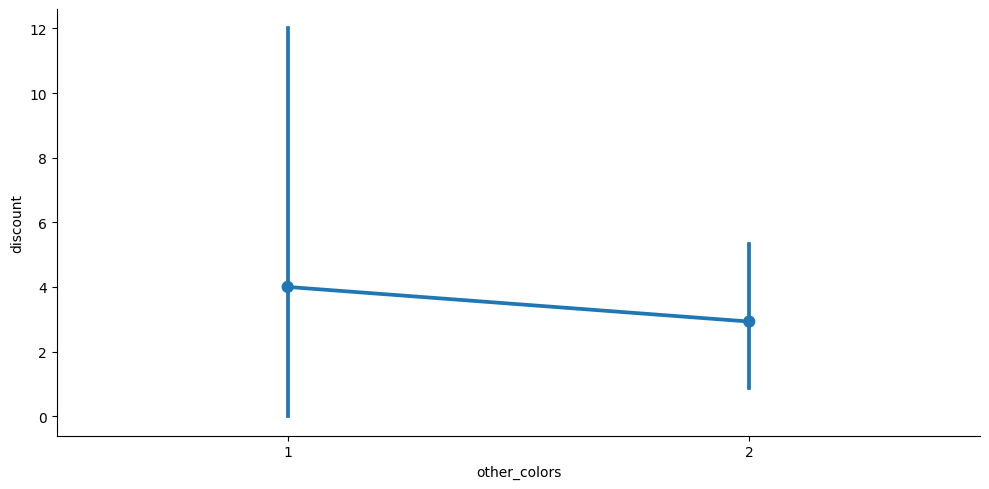

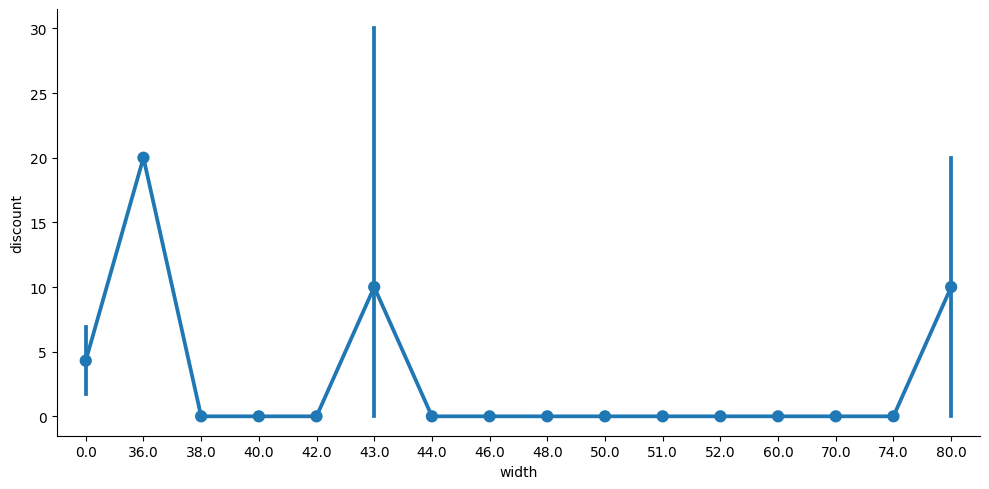

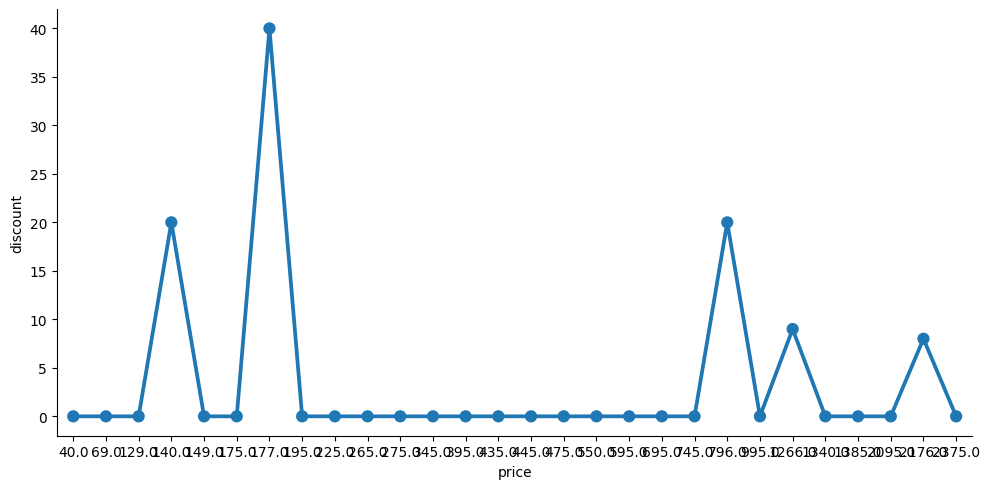

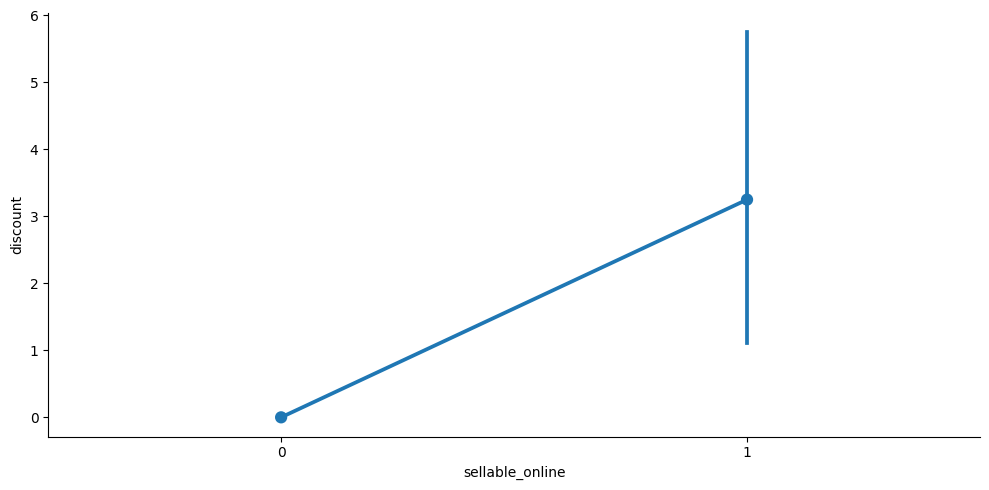

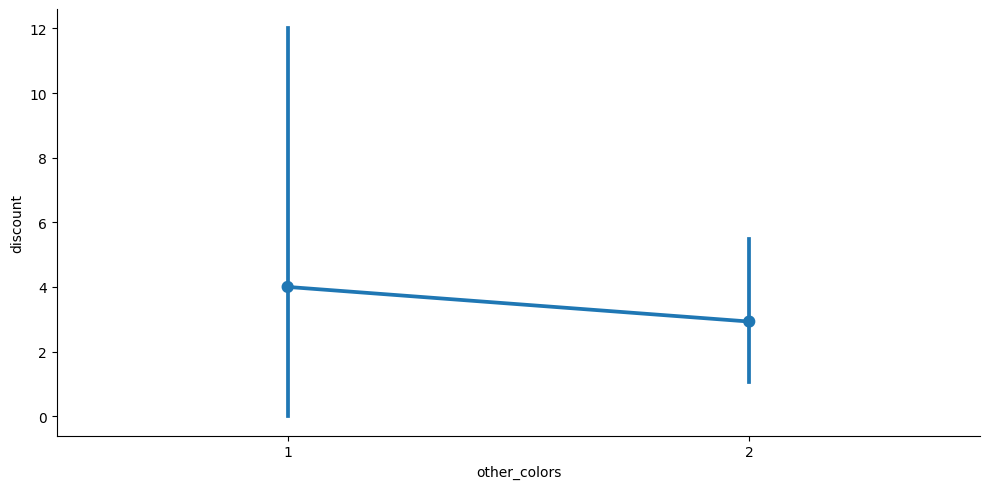

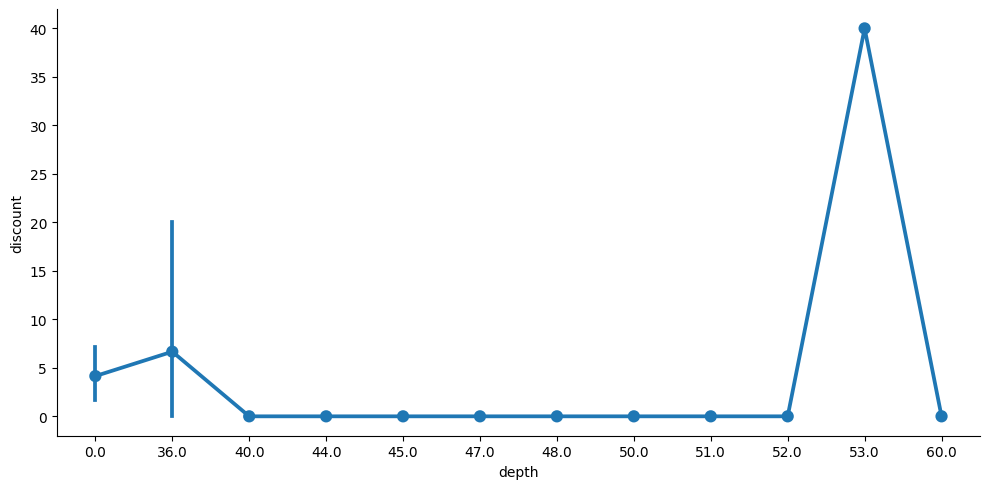

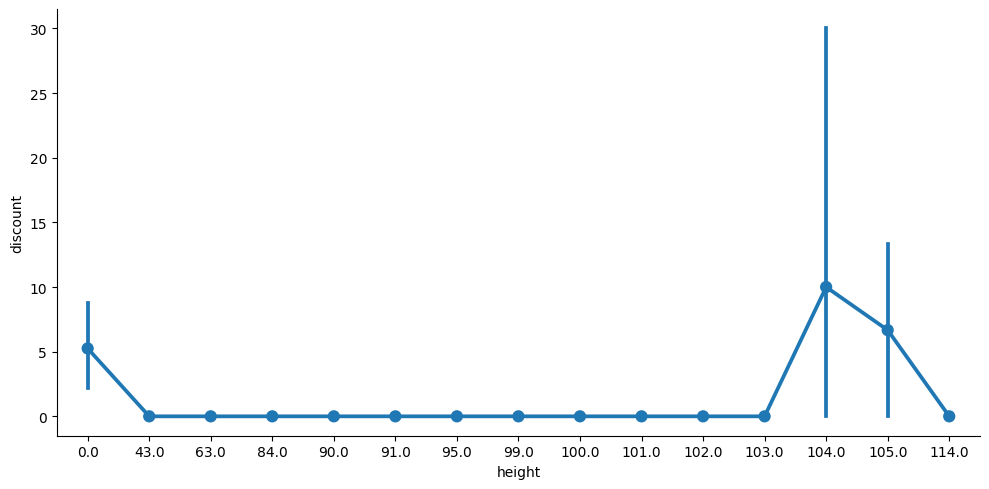

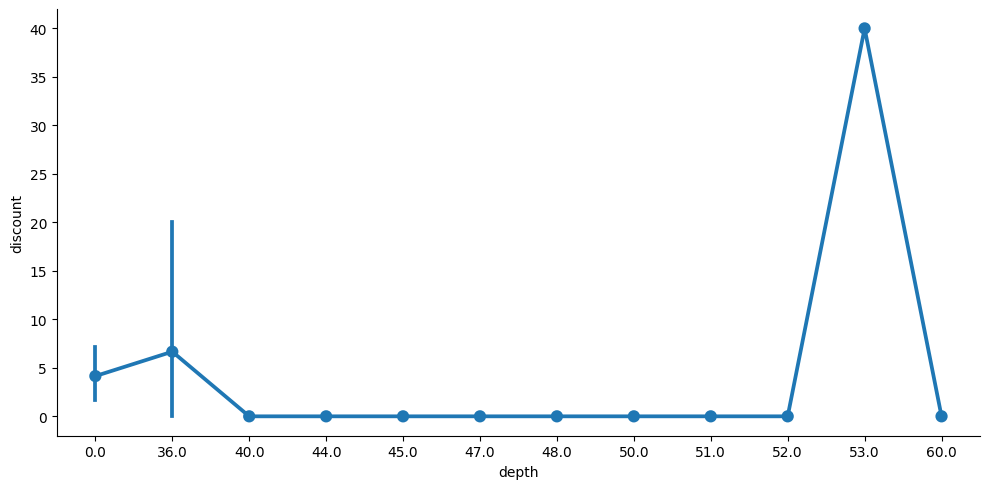

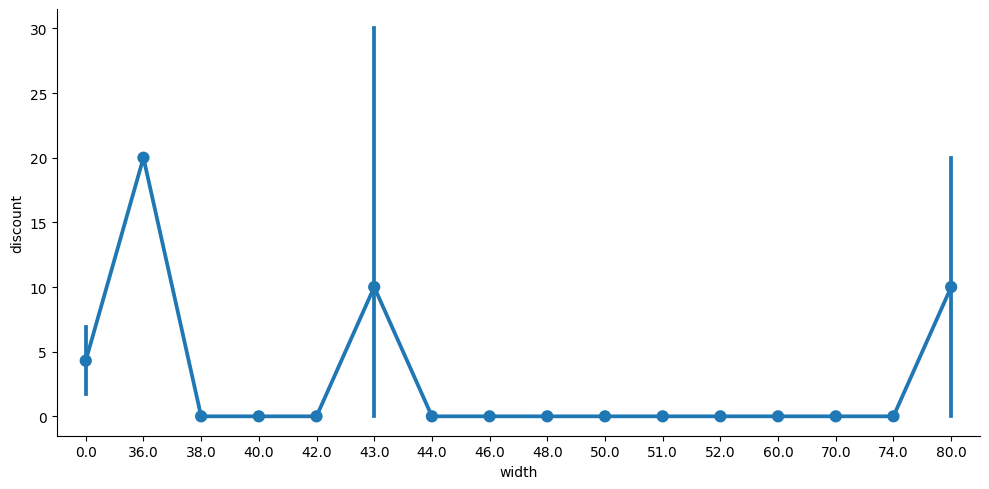

In [21]:
for i in range(1, 18):
    globals()['data{}'.format(i)] = dict()

    if df.loc[df['category'] == i].shape[0] > 0:
        globals()['data{}'.format(i)]  = df.loc[df['category'] == 1, ['price','discount', 'sellable_online','other_colors','depth', 'height','width']]

        for j  , col in enumerate(['price', 'sellable_online','other_colors','depth', 'height','width']):
            plt.figure(i)
            seaborn.catplot(x=col,y='discount', data = globals()['data{}'.format(i)] ,kind='point',aspect=2,)

За графіками видно, що і в кожній категорії простежується залежність від наявності іншого кольору та продажу online. Немає певної залежності від розмірів товару. Немає чіткої лінійної чи регресійної залежності

In [22]:
df.pivot_table('discount',columns='other_colors', aggfunc='mean')#дисконт більше якщо немає іншого кольору

other_colors         1         2
discount      3.108466  3.437672

In [23]:
df.pivot_table('discount',columns='sellable_online', aggfunc='mean')# при продажі onlin дисконт більше

sellable_online         0         1
discount         1.214286  3.318876

In [24]:
df.pivot_table('discount',columns='category', aggfunc='mean')

category        1     2         3         4         5         6     7   \
discount  3.042553  4.25  2.735401  1.585616  2.307692  2.417879  8.12   

category       8         9         10        11        12        13        14  \
discount  0.58871  0.412371  4.768519  9.153846  0.869565  5.415888  1.352632   

category        15   16        17  
discount  2.558824  2.5  6.275424

In [25]:
df.pivot_table('discount',columns='short_description', aggfunc='sum')

short_description          1 sec/storage unit w foldable table,          89x30-104x179 cm  \
discount                                                         0.0                        

short_description          1 section,          44x55x216 cm  \
discount                                               32.0   

short_description          1 section,          52x36x222-350 cm  \
discount                                                   51.0   

short_description          1 section,          78x31x171 cm  \
discount                                                0.0   

short_description          1 section,          84x40x216 cm  \
discount                                               39.0   

short_description          1 section,          84x55x216 cm  \
discount                                               64.0   

short_description          1 section,          92x36x222-350 cm  \
discount                                                   27.0   

short_description          1 section,          92x51x222-350 cm  \
discount                                                    9.0   

short_description          1 section/bottle racks,          89x30x124 cm  \
discount                                                         0.0       

short_description          1 section/shelves,          89x30x179 cm  ...  \
discount                                                        0.0  ...   

short_description          Wardrobe,          80x50x171 cm  \
discount                                               0.0   

short_description          Wardrobe,          80x50x187 cm  \
discount                                               0.0   

short_description          Wardrobe,          88x58x208 cm  \
discount                                               0.0   

short_description          Wardrobe,          95-120x42x181 cm  \
discount                                                  20.0   

short_description          Window table,          80x40x75 cm  \
discount                                                  0.0   

short_description          Wing chair  \
discount                          0.0   

short_description          Wire basket,          25x51x15 cm  \
discount                                                 0.0   

short_description          Wire shelf,          83x50 cm  \
discount                                             0.0   

short_description          Work bench,          110x55 cm  \
discount                                              0.0   

short_description          Work bench,          120x63.5x92 cm  
discount                                                   0.0  

[1 rows x 1706 columns]

In [26]:
df.pivot_table('discount',columns='new_designer', aggfunc='sum')

new_designer  A Fredriksson  A Huldén  Andreas Fredriksson  Anna Efverlund  \
discount                0.0       0.0                  0.0             0.0   

new_designer  Anna Palleschitz  Annie Huldén  C Halskov  C Styrbjörn  \
discount                   0.0           0.0      180.0         20.0   

new_designer  Carina Bengs  Carl Öjerstam  ...  Studio Copenhagen  \
discount             227.0           90.0  ...                0.0   

new_designer  Synnöve Mork  T Christensen  T Winkel  Thomas Sandell  \
discount             113.0            0.0      30.0            60.0   

new_designer  Tina Christensen  Tom Dixon  Tord Björklund  Virgil Abloh  \
discount                  11.0        0.0            26.0         262.0   

new_designer  Wiebke Braasch  
discount                 0.0  

[1 rows x 84 columns]

Використовуємо модель knn, яка найбільше підходить для прогнозу

In [27]:
X = df[['price', 'old_price','category','sellable_online','other_colors','depth', 'height','width']].values  
y = df['discount'].values    

X_train, X_test, y_train, y_test = train_test_split(X, y)


knn = KNeighborsClassifier(n_neighbors=100)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(accuracy_score(y_test, y_pred))

x_new= [[780,980,1,1,0,0,105,80],[2110,2200,15,1,0,0,100,120]]
y_predict = knn.predict(x_new)
y_predict

0.829004329004329


array([0., 0.])

Регресія з використанням алгоритму k-найближчих сусідів 

In [28]:
X = df[['price', 'old_price','category','sellable_online','other_colors','depth', 'height','width']].values  
y = df['discount'].values    

X_train, X_test, y_train, y_test = train_test_split(X, y)

knn = KNeighborsRegressor(n_neighbors=100)
knn.fit(X_train, y_train)
mean_squared_error(y_test, knn.predict(X_test))



48.38447326839827

У цьому коді виконується класифікація з використанням моделі дерева рішень (Decision Tree Classifier) та крос-валідація для оцінки продуктивності моделі.

In [29]:
x = df[['price', 'old_price','category','sellable_online','other_colors']]
y = df['discount']

cif = DecisionTreeClassifier()
scores = cross_val_score(cif, x , y , cv =10)
print(scores)
print(scores.mean())

cif.fit(X_train, y_train)
y_pred = cif.predict(X_test)

x_new= [[780,980,1,1,0,0,105,80],[2110,2200,15,1,0,0,100,120]]
y_predict = knn.predict(x_new)
y_predict

[0.4972973  0.84054054 0.91351351 0.83783784 0.91869919 0.89701897
 0.78861789 0.73712737 0.88617886 0.30081301]
0.7617644473742035


c:\Users\irina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


array([4.48, 2.08])

Для підвищення продуктивності моделі потрібна додаткова інформація про товар. Наприклад, собівартість товару, яка може дати розмір максимальної знижки. Матеріал з якого виготовлен товар. Також наявність дати виготовлення товару, від якої теж може залежати знижка - чим раніше товар виготовлений, тим вірогідніше, отримати більш високу знижку. Необхідно розуміти цінову політику компанії для прогнозування цін. Можливо на знижку може впливати кількість продажів групи товарів, для цього необхідна ознака, яка вказує на можливість отримання знижки.